# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 7

In [2]:
cluster = '7'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 379
Num noneffect sequences: 379


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end        rsid effect noneffect ref    alt  \
37   chr11   86103987   86103988   rs1237999      A         G   G      A   
181  chr17   46130520   46130521  rs10514904      T         C   C      T   
214  chr19   44644418   44644419  rs10426401      T         G   T      G   
342   chr4   89837895   89837896   rs2619363    NAN       NAN   G    C,T   
351   chr5  103120549  103120550     rs26523      T         C   C      T   
35   chr11   86089236   86089237    rs561655      A         G   G      A   
96   chr17   45639518   45639519    rs413778      A         G   A      G   
136  chr17   45852871   45852872  rs79589869      C         A   C      A   
86   chr17   45386126   45386127  rs79724577      C         A   A      C   
347   chr5  102971887  102971888   rs6881225      T         C   T      C   
356   chr6   27754284   27754285   rs4713121      T         C   T      C   
148  chr17   45894775   45894776  rs11575896      G         A   G      A   
107  chr17   45704138   45704139  rs79892630      T         C   C      T   
149  chr17   45895214   45895215  rs74457229      T         C   C      T   
112  chr17   45705326   45705327  rs62056905      G         A   A    G,T   
146  chr17   45894418   45894419  rs11575895      G         A   A      G   
247  chr19   44968484   44968485  rs16979586      G         A   A      G   
208  chr19   18462023   18462024   rs8103622      T         C   C      T   
281   chr2  134707045  134707046  rs57891859      G         A   A      G   
204  chr18   51197068   51197069   rs4396619      T         C   C      T   
162  chr17   45942947   45942948  rs62062772      T         C   C      T   
354   chr5  134587210  134587211  rs17167630      T         C   T      C   
198  chr17   75060504   75060505  rs35041866      T         C   C    G,T   
164  chr17   45947195   45947196  rs62062785      T         G   G    A,T   
232  chr19   44951428   44951429   rs7248162      T         C   T      C   
154  chr17   45897110   45897111  rs76632685      T         A   A      T   
134  chr17   45826179   45826180  rs62057149      G         A   A      G   
298   chr3   49007333   49007334   rs6781790      T         C   C      T   
11   chr10   15515276   15515277    rs896434      T         G   T      G   
353   chr5  103224668  103224669    rs246913      G         C   G      C   
..     ...        ...        ...         ...    ...       ...  ..    ...   
340   chr4   89836157   89836158   rs1372519      A         G   A      G   
173  chr17   46002672   46002673  rs62064663      T         G   T      G   
352   chr5  103120599  103120600     rs26524      G         A   A      G   
314   chr4     958158     958159  rs34311866      T         C   T      C   
145  chr17   45894237   45894238  rs62056778      G         C   C      G   
350   chr5  103041308  103041309   rs6881612      T         C   C      T   
50   chr14   67515536   67515537   rs7154258      T         G   G      T   
190  chr17   75011885   75011886  rs35303667      A         T   T      A   
44   chr12   40230507   40230508  rs11175658      G         A   A      G   
360   chr7   23086302   23086303   rs9691762      C         G   G    A,C   
288   chr2  168247488  168247489  rs76179989      T         G   T      G   
88   chr17   45436184   45436185      rs9730      G         C   C    A,G   
1     chr1  155135690  155135691  rs12726330      G         A   G    A,C   
339   chr4   89836142   89836143   rs1372518    NAN       NAN   A      C   
250  chr19   44989300   44989301  rs11669173      G         A   G      A   
236  chr19   44954888   44954889   rs3760629      A         C   A      C   
133  chr17   45826118   45826119  rs62057148      G         C   G    A,C   
82   chr17    4909107    4909108  rs16954243      A         T   A      T   
245  chr19   44967655   44967656  rs10775543      T         C   C  A,G,T   
143  chr17   45894090   45894091  rs76594404      G         C   G    A,C   
349   chr5  103010211  103010212   rs1826673      G    

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs1237999   ||    chr11 : 86103987 - 86103988   ||    Locus: 37   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.14E-16
Alzheimers_Kunkle_2019 		  1.46E-13
Alzheimers_Lambert_2013 	  4.68E-13

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 1.249   ||   Center / 200bp : 0.501
Noneffect Sequence : ATTATCTATGAGTCACCAAC


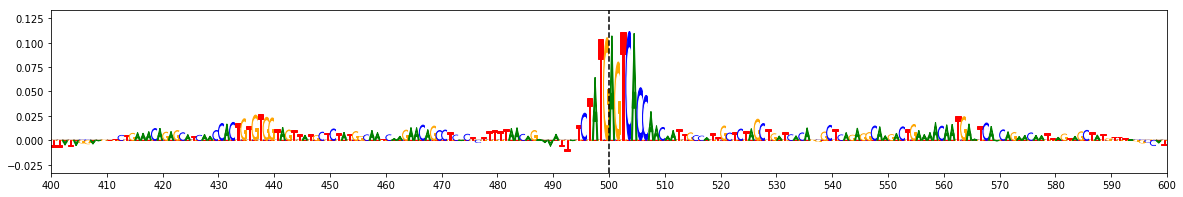

Effect Allele : A   ||   Explain Score : 0.2969   ||   Center / 200bp : 0.1927
Effect Sequence : ATTATCTATAAGTCACCAAC


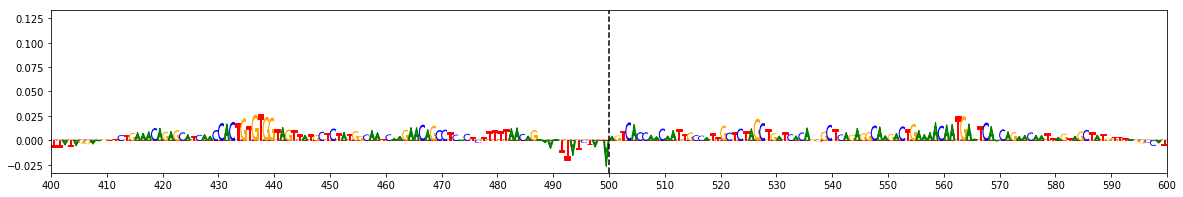

Allele Ratio : 0.2377   ||   Allele Difference : -1.0347  ||  ISM Score : -1.6125  ||  deltaSVM Score : -9.2327


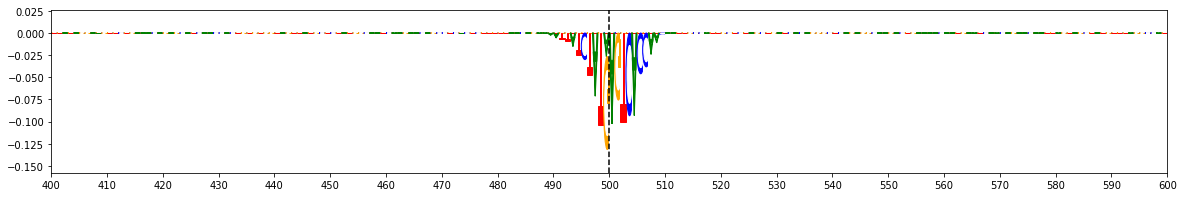


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10514904   ||    chr17 : 46130520 - 46130521   ||    Locus: 181   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.69E-22
Parkinsons_Pankratz_2012 	  4.90E-10

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6817   ||   Center / 200bp : 0.7263
Noneffect Sequence : TGTAAAAGGCTGTTTCATAC


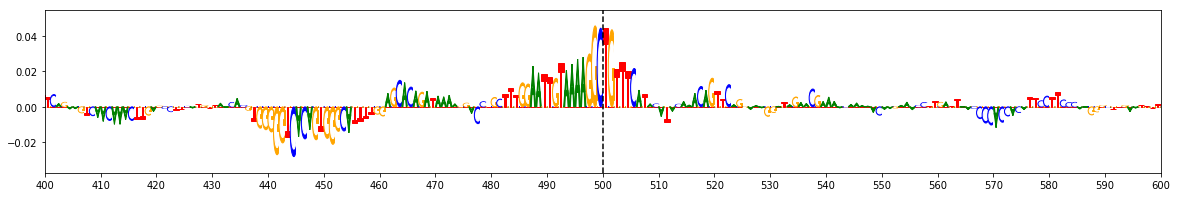

Effect Allele : T   ||   Explain Score : 0.3711   ||   Center / 200bp : 0.5909
Effect Sequence : TGTAAAAGGTTGTTTCATAC


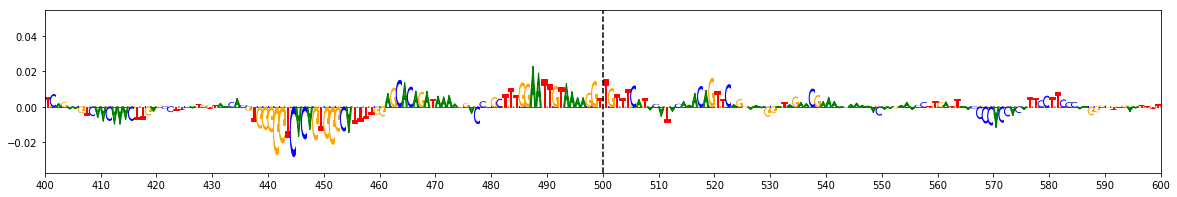

Allele Ratio : 0.5443   ||   Allele Difference : -0.3126  ||  ISM Score : -0.4869  ||  deltaSVM Score : -2.8132


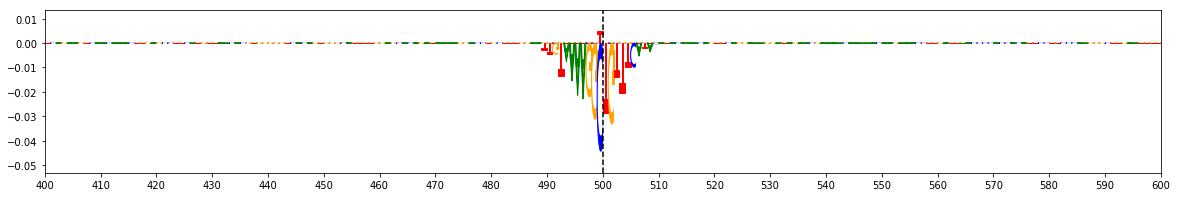


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 214   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.6185   ||   Center / 200bp : 0.4971
Noneffect Sequence : CAACACGGGGCGGGCACAAG


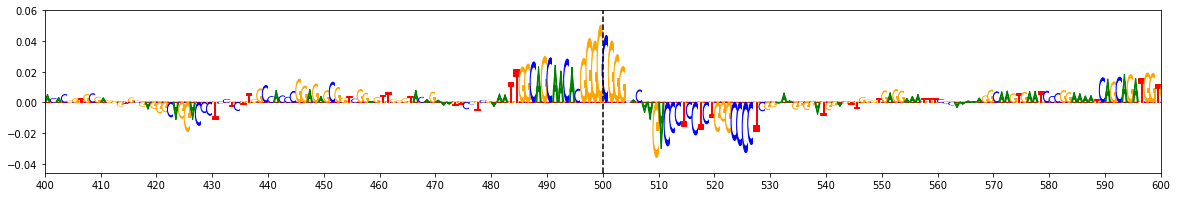

Effect Allele : T   ||   Explain Score : 0.2523   ||   Center / 200bp : 0.2869
Effect Sequence : CAACACGGGTCGGGCACAAG


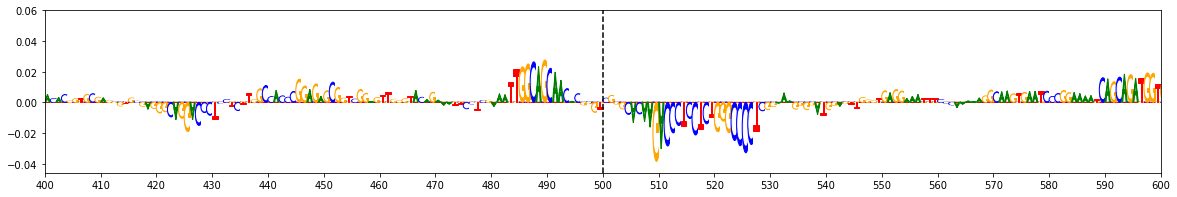

Allele Ratio : 0.4079   ||   Allele Difference : -0.4279  ||  ISM Score : -0.6821  ||  deltaSVM Score : -3.9165


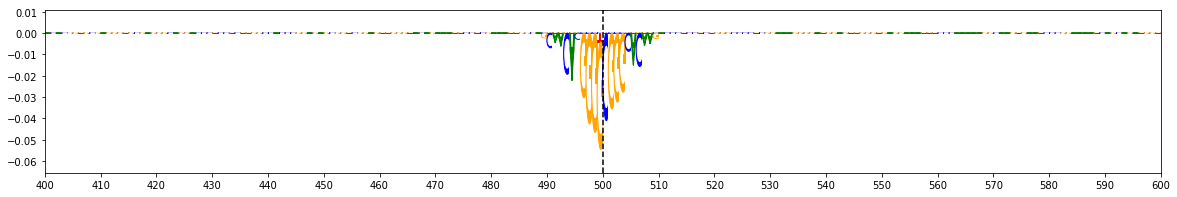


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 342   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.0705   ||   Center / 200bp : 0.6456
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


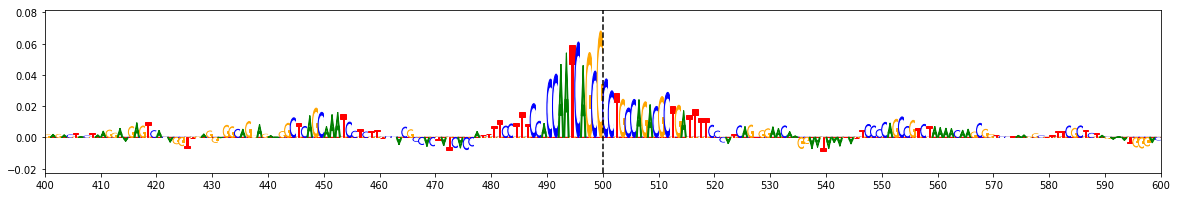

Effect Allele : NAN   ||   Explain Score : 0.5823   ||   Center / 200bp : 0.4958
Effect Sequence : CCAATCAGCCCCTGCCAGAC


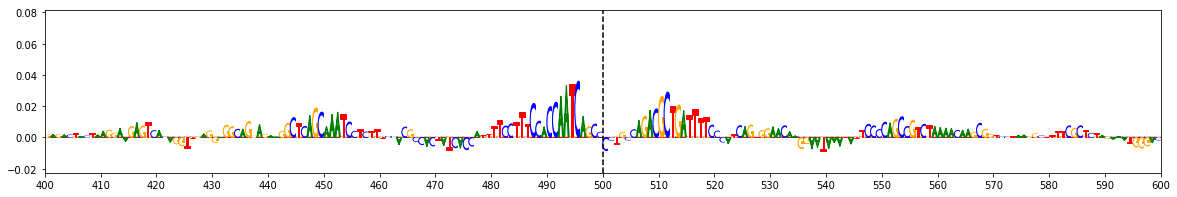

Allele Ratio : 0.544   ||   Allele Difference : -0.5047  ||  ISM Score : -0.7653  ||  deltaSVM Score : -4.6351


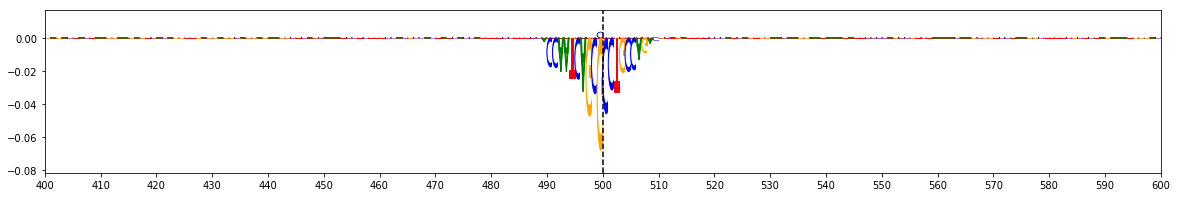


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 351   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.642   ||   Center / 200bp : 0.462
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


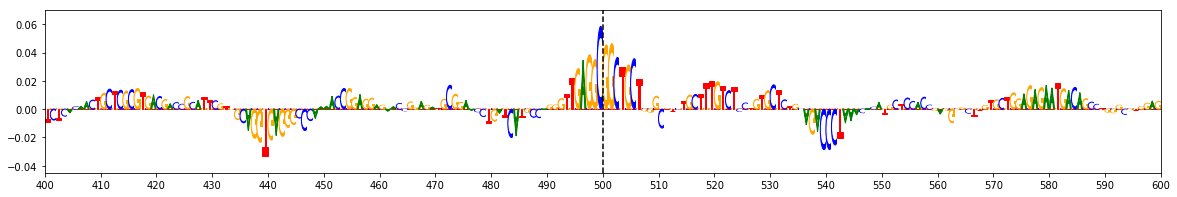

Effect Allele : T   ||   Explain Score : 0.2565   ||   Center / 200bp : 0.2556
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


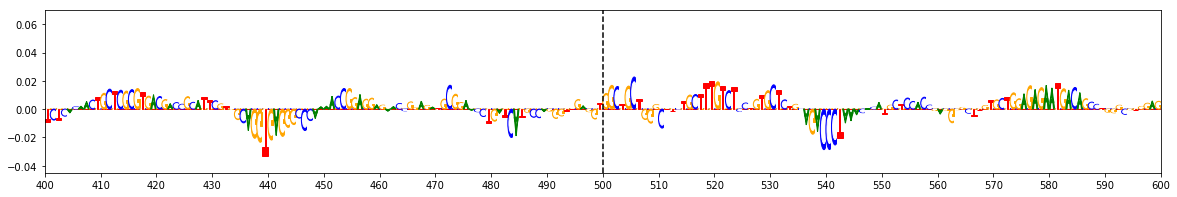

Allele Ratio : 0.3996   ||   Allele Difference : -0.4239  ||  ISM Score : -0.6624  ||  deltaSVM Score : -3.8224


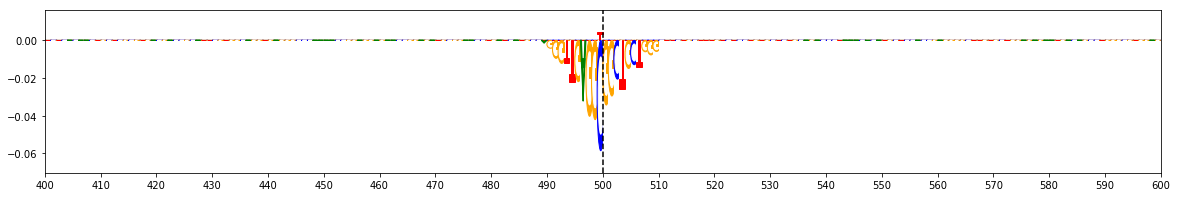


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs561655   ||    chr11 : 86089236 - 86089237   ||    Locus: 35   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  3.13E-17
Alzheimers_Kunkle_2019 		  1.27E-14
Alzheimers_Lambert_2013 	  1.59E-13

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.5116   ||   Center / 200bp : 0.6322
Noneffect Sequence : GGTAATTCCGACATTAAAGG


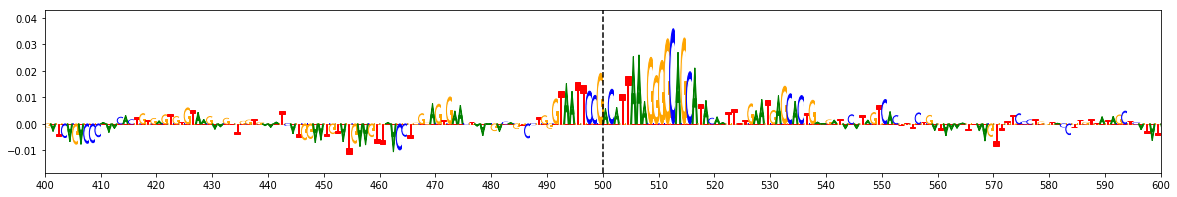

Effect Allele : A   ||   Explain Score : 0.3261   ||   Center / 200bp : 0.5231
Effect Sequence : GGTAATTCCAACATTAAAGG


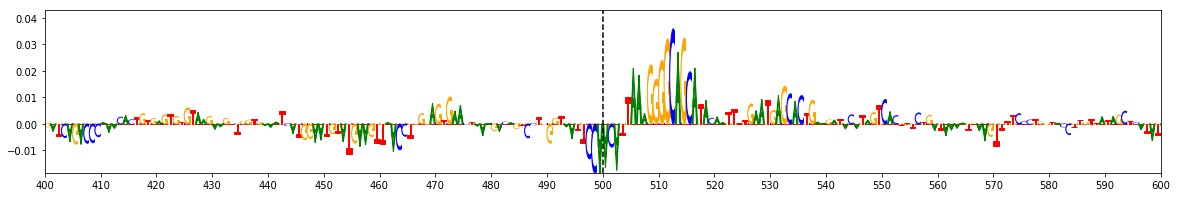

Allele Ratio : 0.6373   ||   Allele Difference : -0.3057  ||  ISM Score : -0.4772  ||  deltaSVM Score : -2.7549


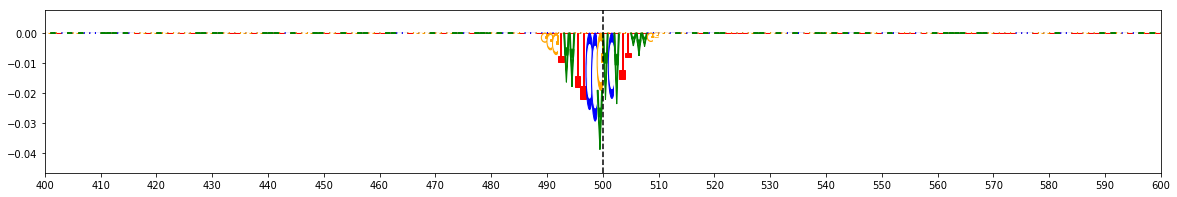


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs413778   ||    chr17 : 45639518 - 45639519   ||    Locus: 96   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.96E-22
Parkinsons_Pankratz_2012 	  2.17E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.4045   ||   Center / 200bp : 0.6339
Noneffect Sequence : GGTGAGTCAGAGTAAGTATA


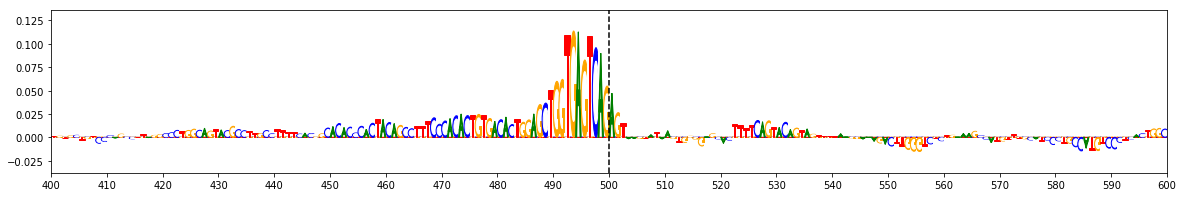

Effect Allele : A   ||   Explain Score : 0.953   ||   Center / 200bp : 0.5401
Effect Sequence : GGTGAGTCAAAGTAAGTATA


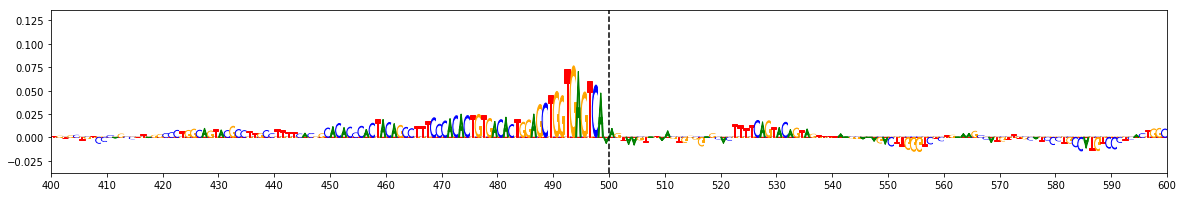

Allele Ratio : 0.6785   ||   Allele Difference : -0.4829  ||  ISM Score : -0.7522  ||  deltaSVM Score : -4.4001


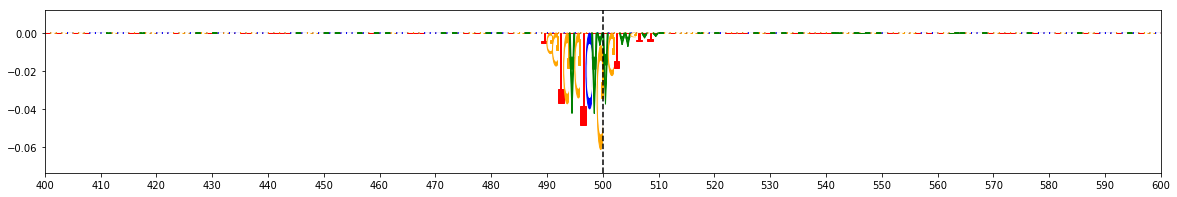


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79589869   ||    chr17 : 45852871 - 45852872   ||    Locus: 136   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.11E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.7829   ||   Center / 200bp : 0.8618
Noneffect Sequence : TTGAATGCTACTGTGCTGCC


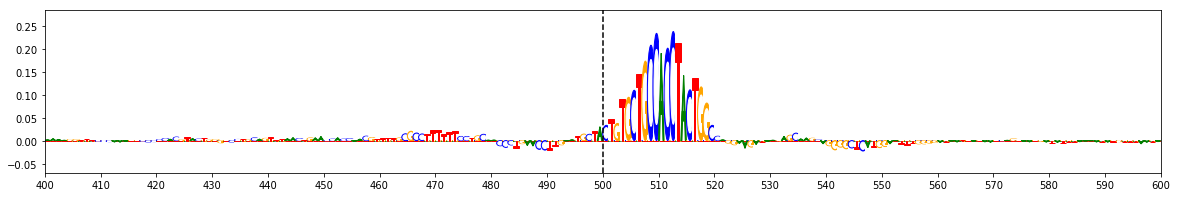

Effect Allele : C   ||   Explain Score : 2.585   ||   Center / 200bp : 0.8528
Effect Sequence : TTGAATGCTCCTGTGCTGCC


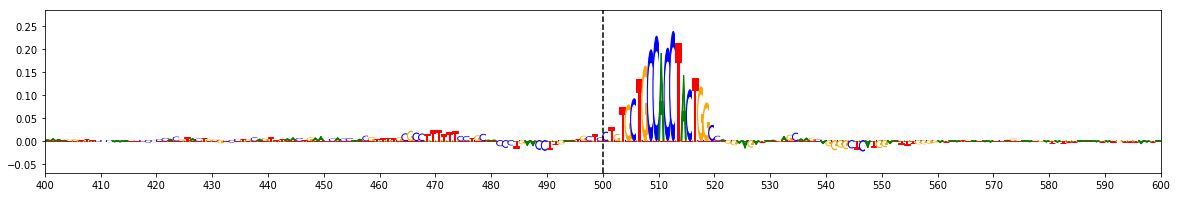

Allele Ratio : 0.9289   ||   Allele Difference : -0.1919  ||  ISM Score : -0.3007  ||  deltaSVM Score : -1.7305


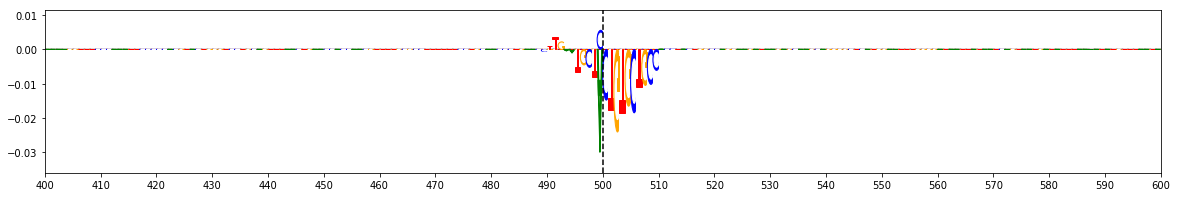


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79724577   ||    chr17 : 45386126 - 45386127   ||    Locus: 86   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  5.92E-20

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.9642   ||   Center / 200bp : 0.6166
Noneffect Sequence : AAGGTTGCCAGGGATTAGGG


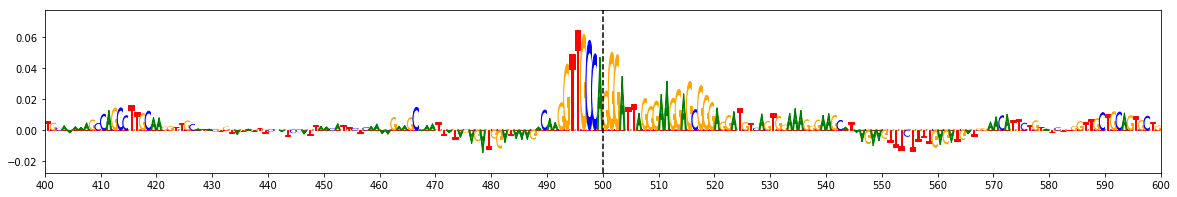

Effect Allele : C   ||   Explain Score : 0.6458   ||   Center / 200bp : 0.5185
Effect Sequence : AAGGTTGCCCGGGATTAGGG


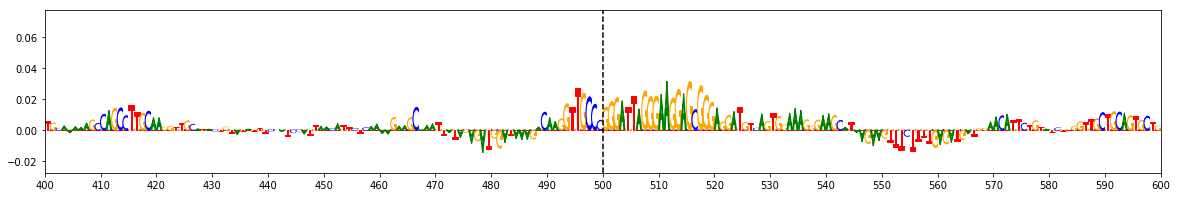

Allele Ratio : 0.6698   ||   Allele Difference : -0.3184  ||  ISM Score : -0.5017  ||  deltaSVM Score : -2.8723


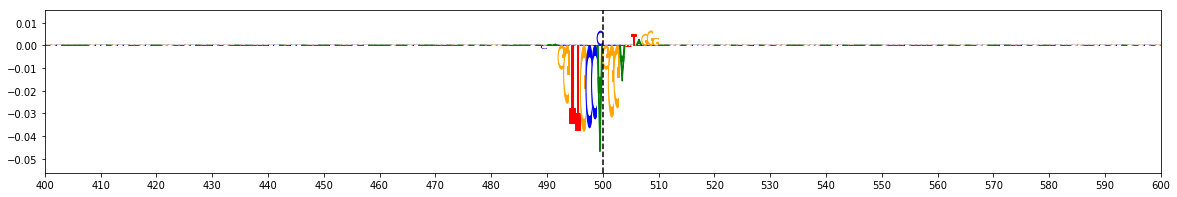


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6881225   ||    chr5 : 102971887 - 102971888   ||    Locus: 347   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.13E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 2.2527   ||   Center / 200bp : 0.7766
Noneffect Sequence : TGTAAGAGACAGCCATCTAG


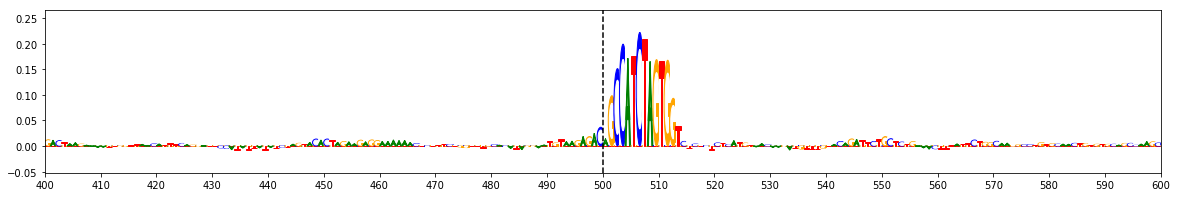

Effect Allele : T   ||   Explain Score : 1.9183   ||   Center / 200bp : 0.7477
Effect Sequence : TGTAAGAGATAGCCATCTAG


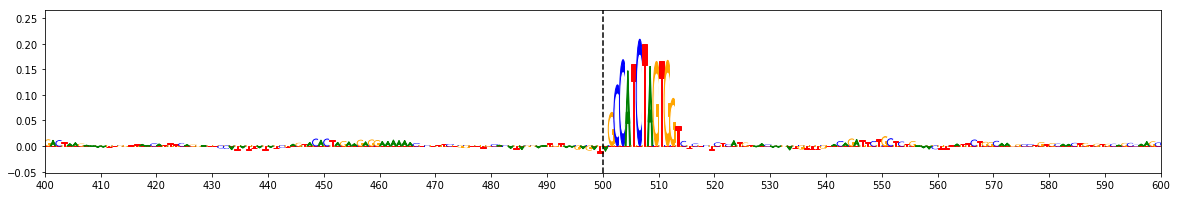

Allele Ratio : 0.8515   ||   Allele Difference : -0.3913  ||  ISM Score : -0.6137  ||  deltaSVM Score : -3.5008


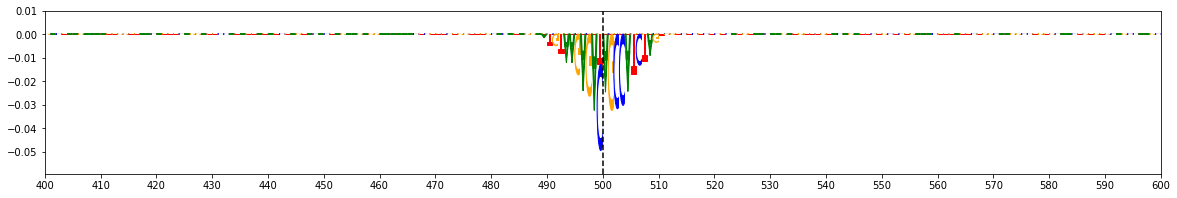


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4713121   ||    chr6 : 27754284 - 27754285   ||    Locus: 356   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.30E-05

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.3383   ||   Center / 200bp : 0.6841
Noneffect Sequence : GCAACGCCCCGAACGGTGGG


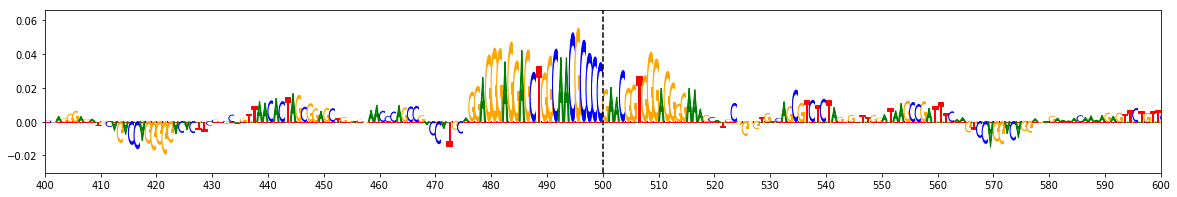

Effect Allele : T   ||   Explain Score : 1.0172   ||   Center / 200bp : 0.6221
Effect Sequence : GCAACGCCCTGAACGGTGGG


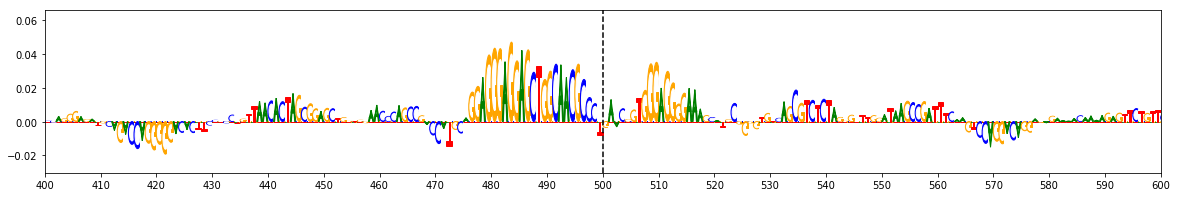

Allele Ratio : 0.7601   ||   Allele Difference : -0.3355  ||  ISM Score : -0.5241  ||  deltaSVM Score : -3.0341


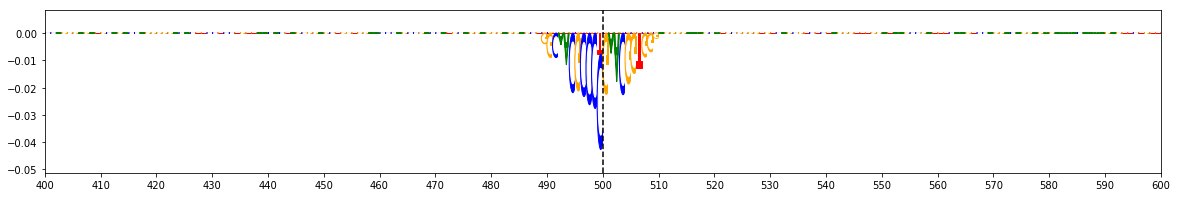


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 148   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.7233   ||   Center / 200bp : 0.647
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


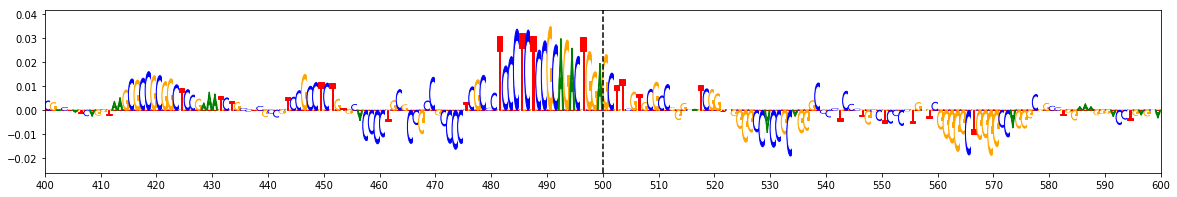

Effect Allele : G   ||   Explain Score : 0.5433   ||   Center / 200bp : 0.5794
Effect Sequence : GCAGACTGGGGCTTCGTGCG


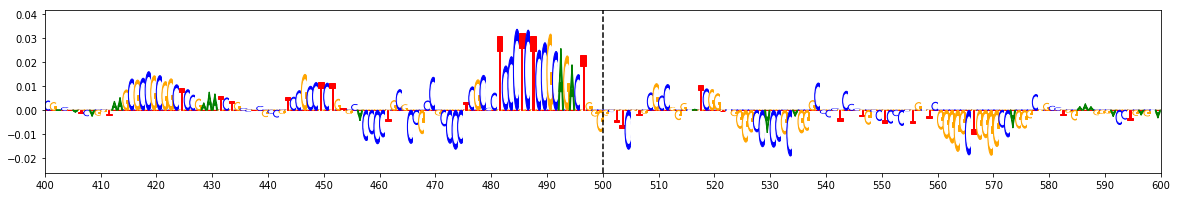

Allele Ratio : 0.7512   ||   Allele Difference : -0.2259  ||  ISM Score : -0.3629  ||  deltaSVM Score : -2.0698


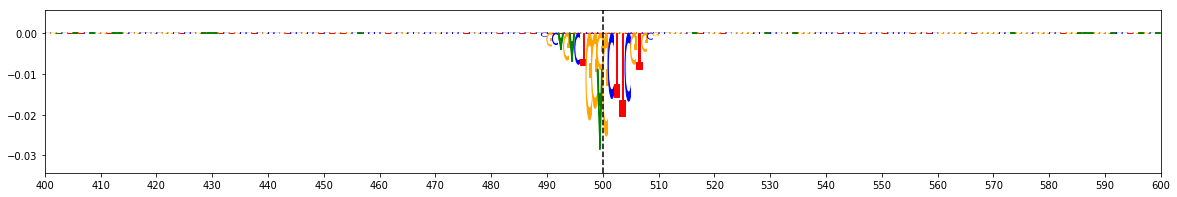


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79892630   ||    chr17 : 45704138 - 45704139   ||    Locus: 107   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.13E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.5371   ||   Center / 200bp : 0.6633
Noneffect Sequence : TCTTTTTTTCCTCTCATCTG


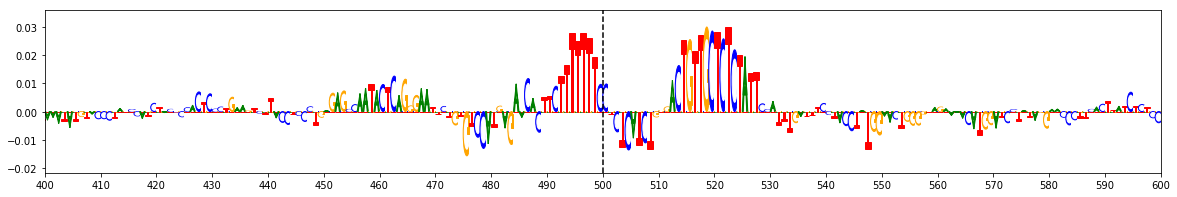

Effect Allele : T   ||   Explain Score : 0.4176   ||   Center / 200bp : 0.6068
Effect Sequence : TCTTTTTTTTCTCTCATCTG


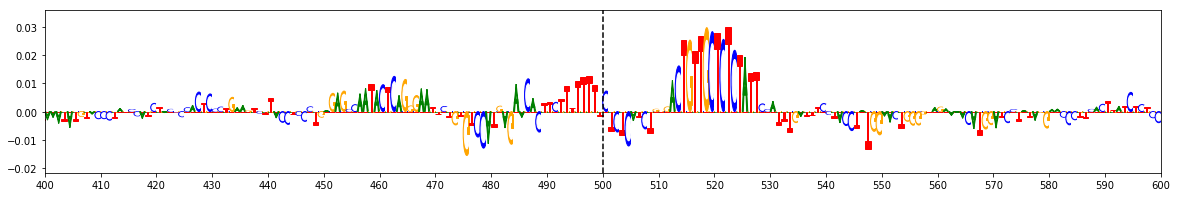

Allele Ratio : 0.7776   ||   Allele Difference : -0.0918  ||  ISM Score : -0.1452  ||  deltaSVM Score : -0.8145


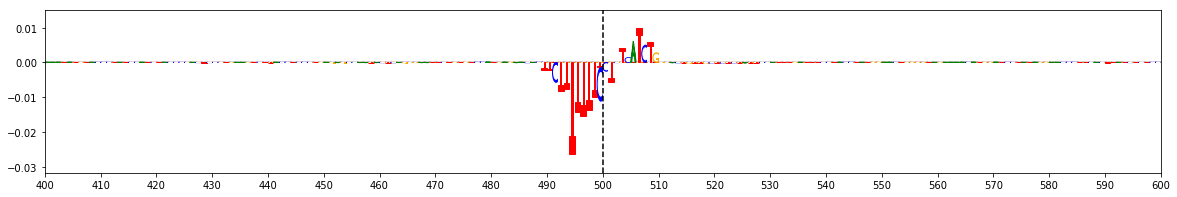


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs74457229   ||    chr17 : 45895214 - 45895215   ||    Locus: 149   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.9811   ||   Center / 200bp : 0.6953
Noneffect Sequence : ACGCCCCTCCCTGCACCTCC


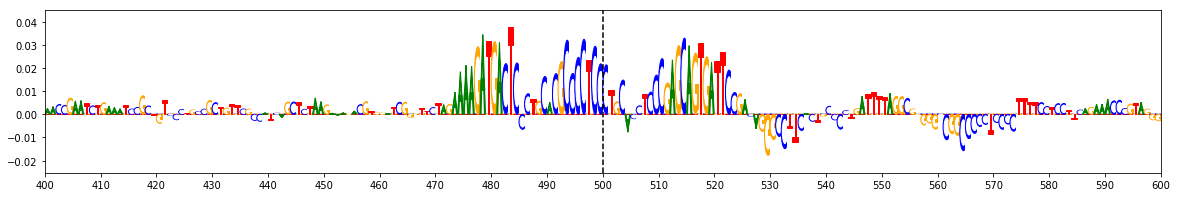

Effect Allele : T   ||   Explain Score : 0.804   ||   Center / 200bp : 0.6498
Effect Sequence : ACGCCCCTCTCTGCACCTCC


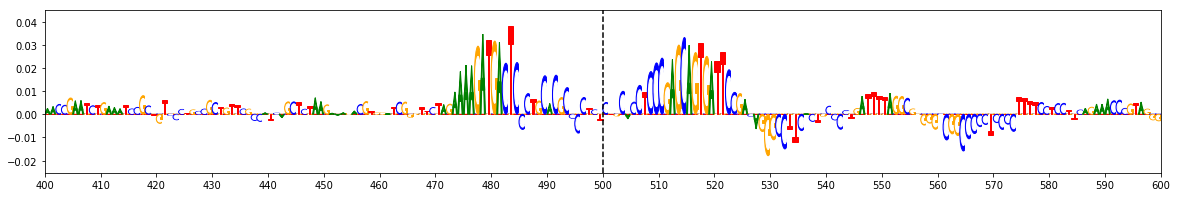

Allele Ratio : 0.8195   ||   Allele Difference : -0.1824  ||  ISM Score : -0.2983  ||  deltaSVM Score : -1.8406


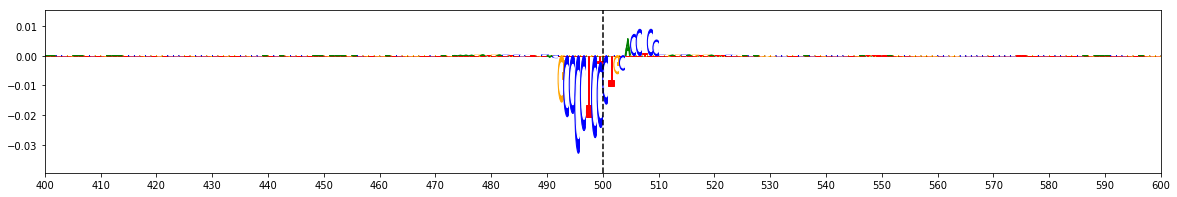


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056905   ||    chr17 : 45705326 - 45705327   ||    Locus: 112   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  9.27E-23

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.7359   ||   Center / 200bp : 0.6358
Noneffect Sequence : GGGCCAGTCATCTCTCACTC


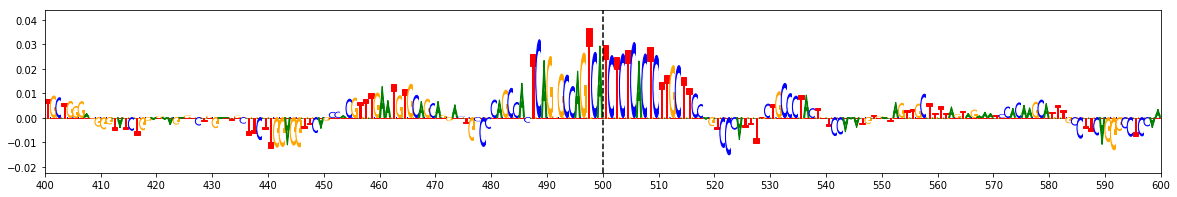

Effect Allele : G   ||   Explain Score : 0.5593   ||   Center / 200bp : 0.5702
Effect Sequence : GGGCCAGTCGTCTCTCACTC


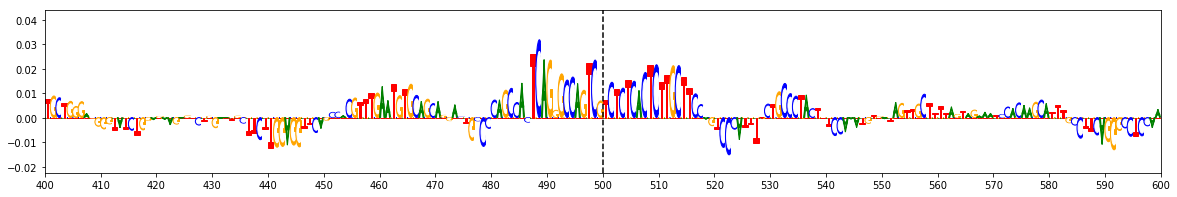

Allele Ratio : 0.76   ||   Allele Difference : -0.1766  ||  ISM Score : -0.2764  ||  deltaSVM Score : -1.5763


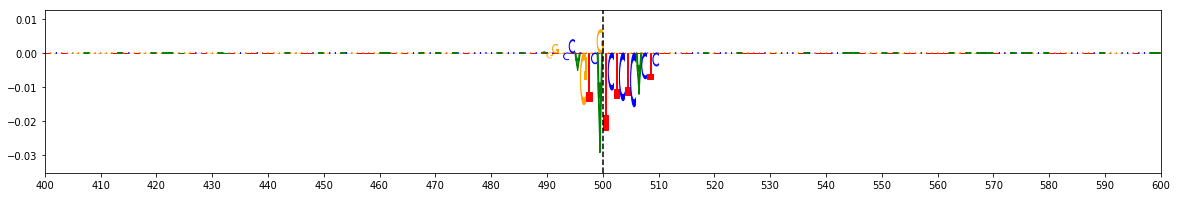


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 146   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.3226   ||   Center / 200bp : 0.7225
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


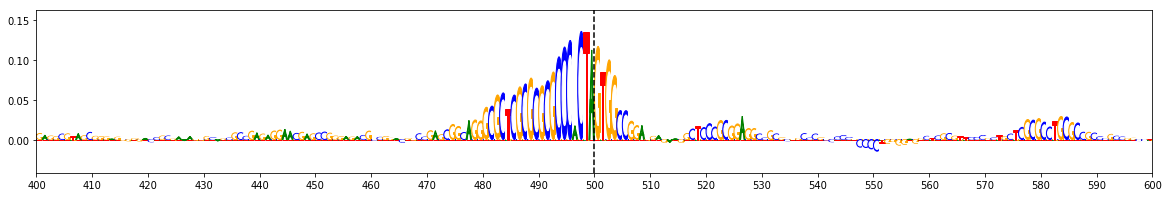

Effect Allele : G   ||   Explain Score : 2.0071   ||   Center / 200bp : 0.6903
Effect Sequence : GCGCCCACTGGTGGCCGGAG


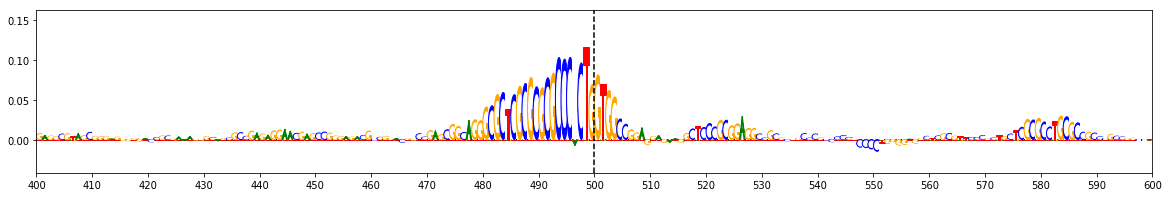

Allele Ratio : 0.8642   ||   Allele Difference : -0.3297  ||  ISM Score : -0.4801  ||  deltaSVM Score : -3.3096


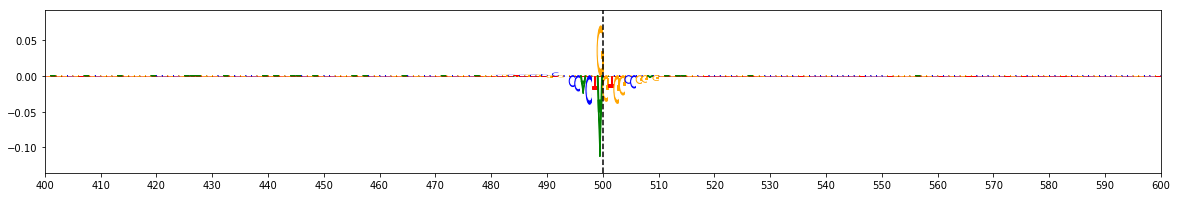


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs16979586   ||    chr19 : 44968484 - 44968485   ||    Locus: 247   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  3.01E-23
Alzheimers_Kunkle_2019 		  9.56E-15
Alzheimers_Lambert_2013 	  3.75E-11

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.2682   ||   Center / 200bp : 0.6171
Noneffect Sequence : GTGGGAGAAAGGATTTAATG


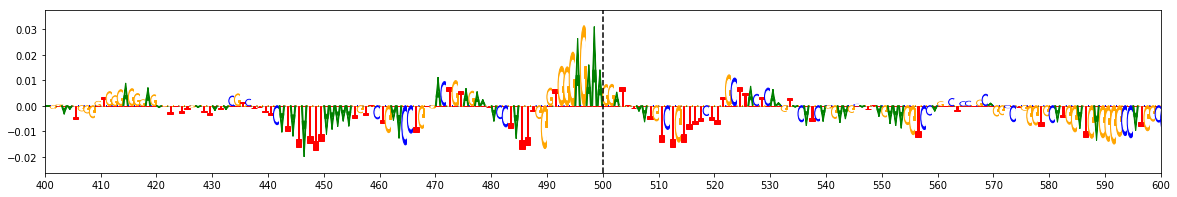

Effect Allele : G   ||   Explain Score : 0.1999   ||   Center / 200bp : 0.5457
Effect Sequence : GTGGGAGAAGGGATTTAATG


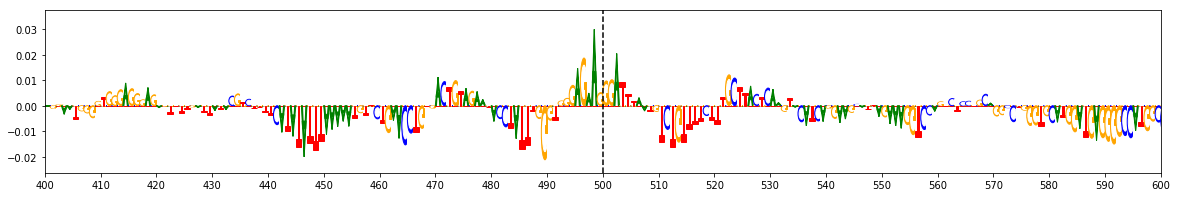

Allele Ratio : 0.7453   ||   Allele Difference : -0.0694  ||  ISM Score : -0.1087  ||  deltaSVM Score : -0.6629


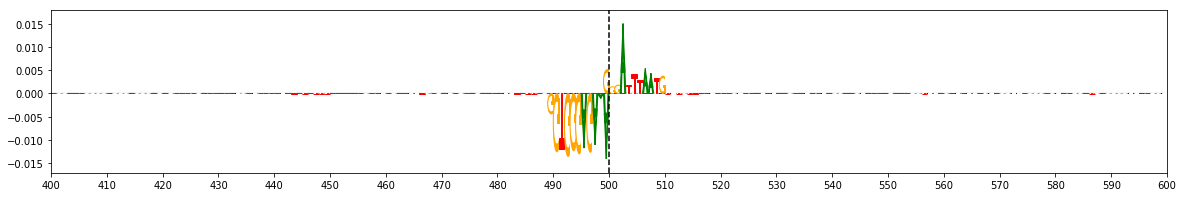


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 208   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  7.31E-02
Alzheimers_Kunkle_2019 		  1.28E-05
Alzheimers_Lambert_2013 	  3.29E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.7783   ||   Center / 200bp : 0.6483
Noneffect Sequence : GACCAAGAGCGCCACCTGCT


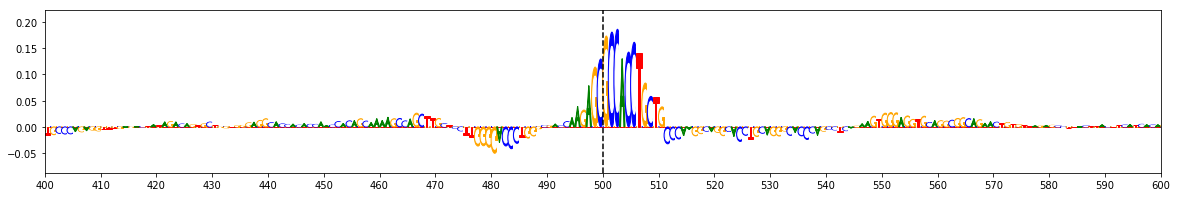

Effect Allele : T   ||   Explain Score : 1.4148   ||   Center / 200bp : 0.5948
Effect Sequence : GACCAAGAGTGCCACCTGCT


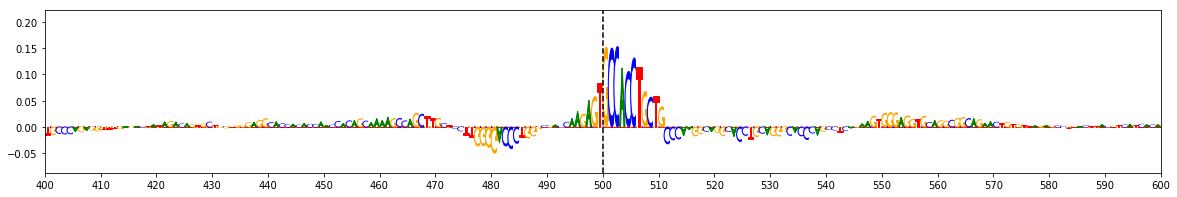

Allele Ratio : 0.7956   ||   Allele Difference : -0.3631  ||  ISM Score : -0.5967  ||  deltaSVM Score : -3.4072


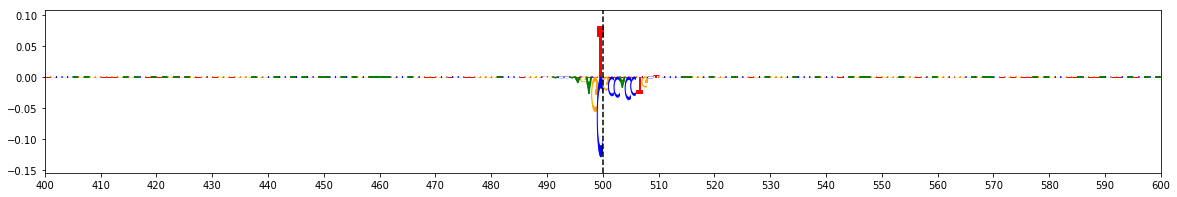


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs57891859   ||    chr2 : 134707045 - 134707046   ||    Locus: 281   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  3.16E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.0911   ||   Center / 200bp : 0.6652
Noneffect Sequence : ATCGTTCCCAAGCACACCCA


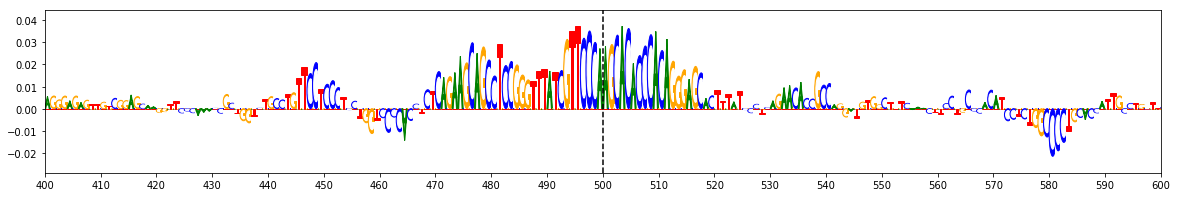

Effect Allele : G   ||   Explain Score : 0.9429   ||   Center / 200bp : 0.6317
Effect Sequence : ATCGTTCCCGAGCACACCCA


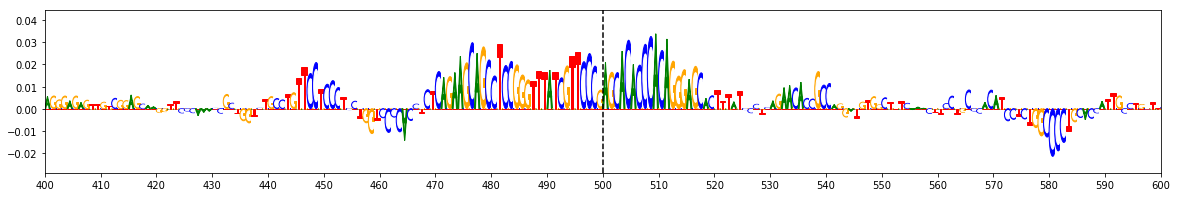

Allele Ratio : 0.8642   ||   Allele Difference : -0.1482  ||  ISM Score : -0.2325  ||  deltaSVM Score : -1.332


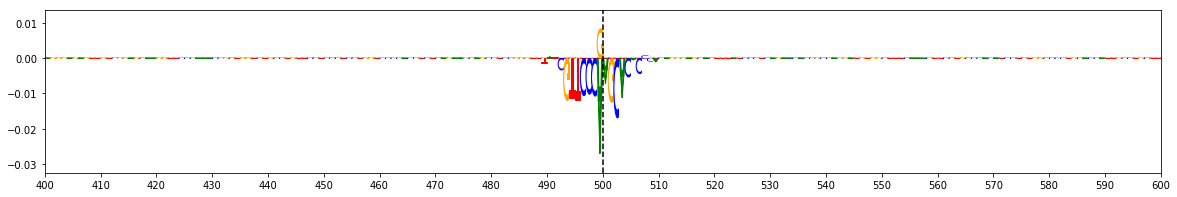


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4396619   ||    chr18 : 51197068 - 51197069   ||    Locus: 204   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.34E-04

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9389   ||   Center / 200bp : 0.5491
Noneffect Sequence : CAGCTCCGCCGCCCGCCGGG


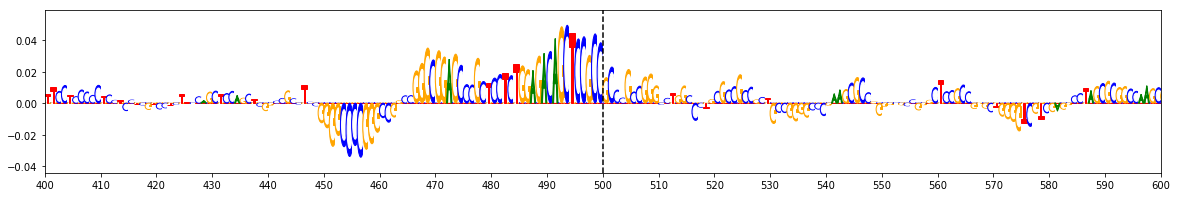

Effect Allele : T   ||   Explain Score : 0.6796   ||   Center / 200bp : 0.4662
Effect Sequence : CAGCTCCGCTGCCCGCCGGG


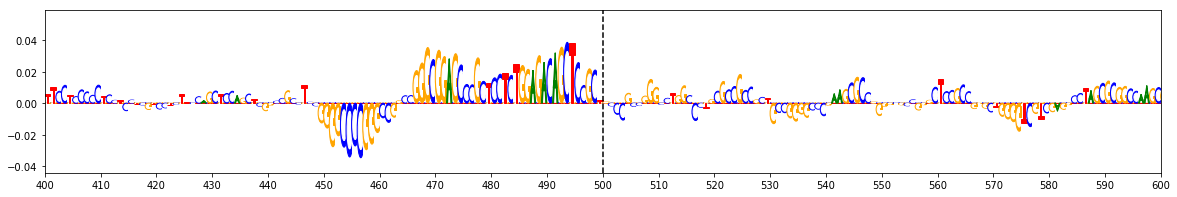

Allele Ratio : 0.7238   ||   Allele Difference : -0.2827  ||  ISM Score : -0.5048  ||  deltaSVM Score : -2.9754


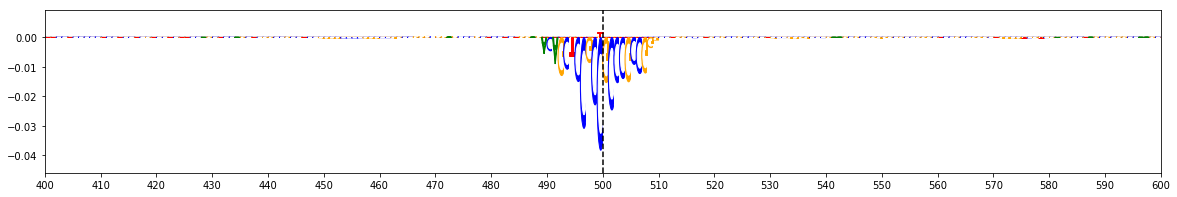


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
67   chr16   31009756   31009757    rs7184567      T         C           C   
319   chr4     987143     987144   rs10902762      G         A           G   
177  chr17   46038519   46038520   rs12150090      T         C           C   
253  chr19   45039212   45039213   rs34034621      T         C           C   
305   chr3   52498433   52498434  rs181391313      G         A           G   
13   chr10   80493944   80493945    rs7900536      A         C           C   
79   chr16   50702744   50702745    rs6500328      G         A           A   
270   chr2  127084806  127084807   rs11691237      T         C           C   
153  chr17   45897109   45897110   rs80346216      T         G           G   
346   chr5  102959365  102959366    rs3776870      G         A           G   
8     chr1  232508907  232508908   rs12073680      G         A           A   
135  chr17   45826181   45826182   rs62057150      T         C           C   
257  chr19   45130427   45130428     rs754366      A         G           G   
187  chr17   46771150   46771151     rs199523      C         A           C   
113  chr17   45705341   45705342   rs62056906      T         C           T   
169  chr17   45958680   45958681   rs62063271      G         A           G   
7     chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
34   chr11   86069405   86069406    rs3016327      T         C           T   
129  chr17   45819270   45819271   rs62057109      T         C           T   
182  chr17   46130533   46130534  rs142524806      I         D           A   
370   chr8   22599691   22599692     rs755934      T         G           T   
365   chr7   23205949   23205950     rs858295      G         A           A   
285   chr2  134718389  134718390   rs62171393      G         C           C   
122  chr17   45775742   45775743   rs55787105      G         A           G   
200  chr17   78432471   78432472    rs7212019      G         A           G   
262   chr2   95076932   95076933    rs3105101      C         A           C   
293   chr3   48692682   48692683   rs12493578      T         C           T   
331   chr4   89829438   89829439    rs2737005      G         A           A   
53   chr14   67517391   67517392    rs7144624      T         G           G   
137  chr17   45861267   45861268   rs62054846      G         A           A   
..     ...        ...        ...          ...    ...       ...         ...   
316   chr4     973656     973657   rs13137144      G         A           G   
290  chr20   56422511   56422512    rs6024870      A         G           G   
4     chr1  205694349  205694350   rs12118655      G         A           A   
357   chr6   27762284   27762285    rs9295746      T         C           T   
171  chr17   46002200   46002201   rs17573447      T         C           C   
170  chr17   45966011   45966012   rs62063291      T         C           T   
26   chr11   47426945   47426946   rs11600581      T         C           T   
155  chr17   45897182   45897183   rs62056783      G         C           G   
372   chr8   22623005   22623006   rs11780207      G         A           G   
157  chr17   45914414   45914415   rs17564020      T         G           G   
344   chr5  102910364  102910365   rs17154825      T         C           T   
16   chr10  119651404  119651405  rs144814361      T         C           C   
161  chr17   45942915   45942916   rs62062771      G         A           G   
217  chr19   44758447   44758448   rs34967149      T         C           C   
185  chr17   46192692   46192693    rs2696633      T         A           A   
71   chr16   31074148   31074149    rs2303222      T         C           T   
183  chr17   46130565   46130566   rs79301522      G         A           A   
18   chr11   10522376   10522377    rs7123581      C         A           C   
325   chr4   89753299   89753300    rs3756054      T         C           T   
119  chr17   45741244   45741

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs7184567   ||    chr16 : 31009756 - 31009757   ||    Locus: 67   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  2.10E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.0549   ||  Center / 200bp: 0.1265
Effect Sequence: TCTGCATCCTCATCTCCCAC


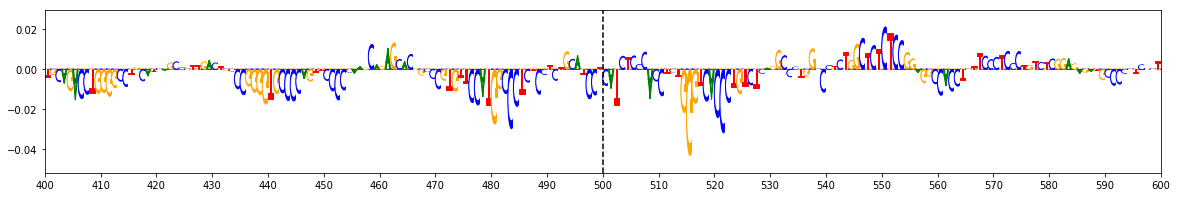

Noneffect Allele: C   ||  Explain Score: 0.0025   ||  Center / 200bp: 0.0064
Noneffect Sequence: TCTGCATCCCCATCTCCCAC


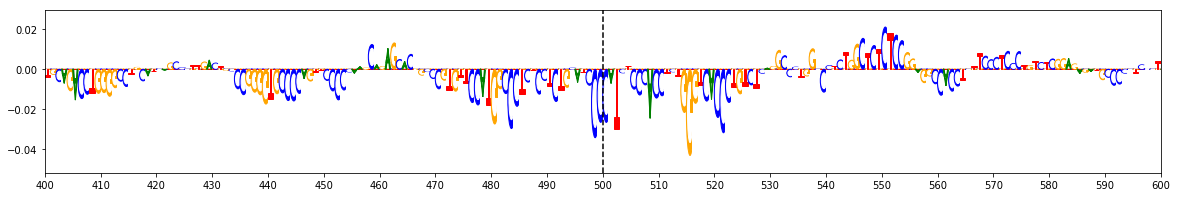

Allele Ratio : 22.2554   ||   Allele Difference : 0.2194  ||  ISM Score : 0.3506  ||  deltaSVM Score : 2.102


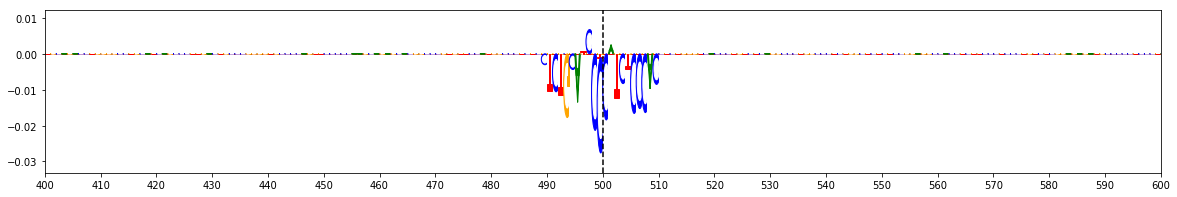


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10902762   ||    chr4 : 987143 - 987144   ||    Locus: 319   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.90E-11

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3656   ||  Center / 200bp: 0.4442
Effect Sequence: CCTGGCCGCGCCCCCGGTGG


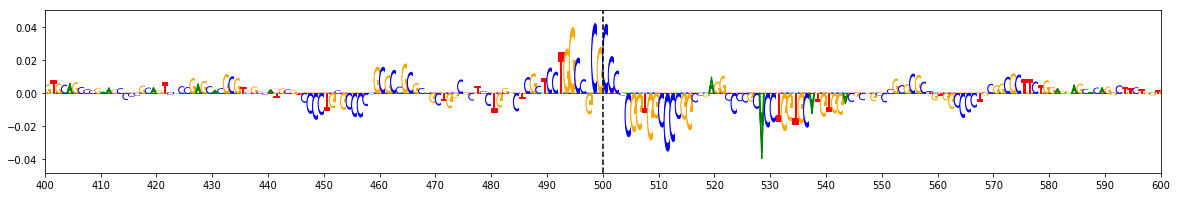

Noneffect Allele: A   ||  Explain Score: 0.1243   ||  Center / 200bp: 0.2111
Noneffect Sequence: CCTGGCCGCACCCCCGGTGG


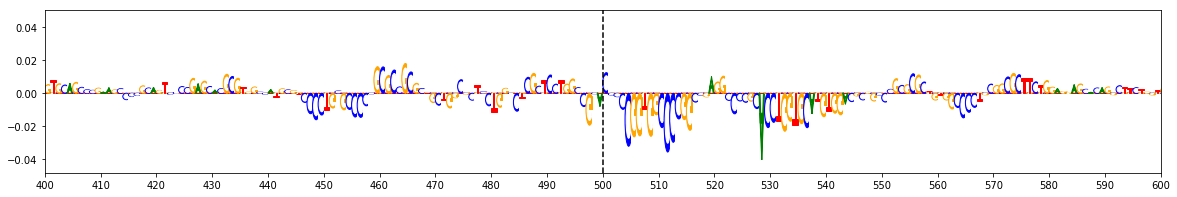

Allele Ratio : 2.9406   ||   Allele Difference : 0.2861  ||  ISM Score : 0.4666  ||  deltaSVM Score : 2.7806


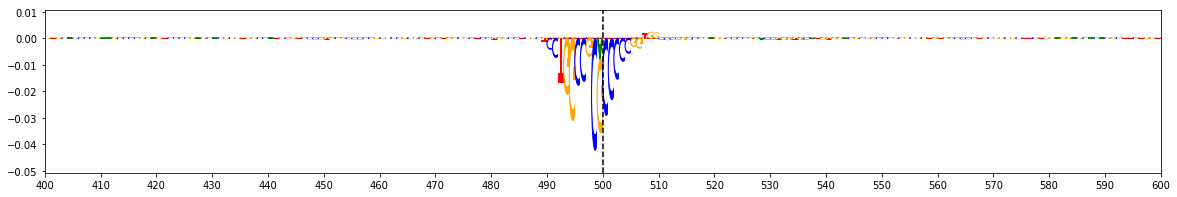


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12150090   ||    chr17 : 46038519 - 46038520   ||    Locus: 177   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.51E-22
Parkinsons_Pankratz_2012 	  4.06E-10

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.7527   ||  Center / 200bp: 0.4198
Effect Sequence: TCCGGCCAATCCCACACAGG


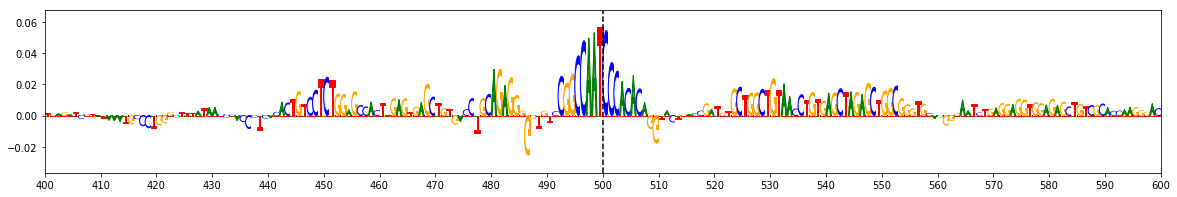

Noneffect Allele: C   ||  Explain Score: 0.2673   ||  Center / 200bp: 0.2048
Noneffect Sequence: TCCGGCCAACCCCACACAGG


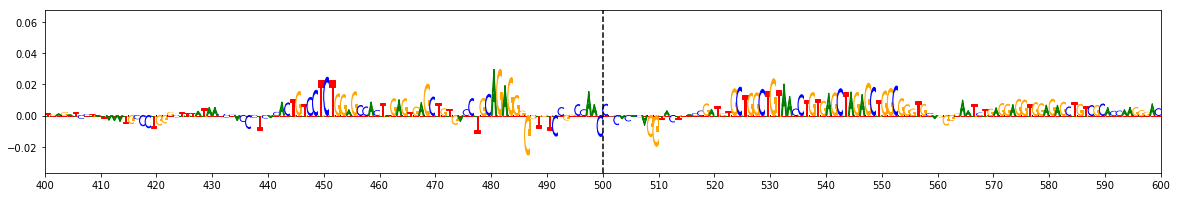

Allele Ratio : 2.816   ||   Allele Difference : 0.5472  ||  ISM Score : 0.855  ||  deltaSVM Score : 4.9616


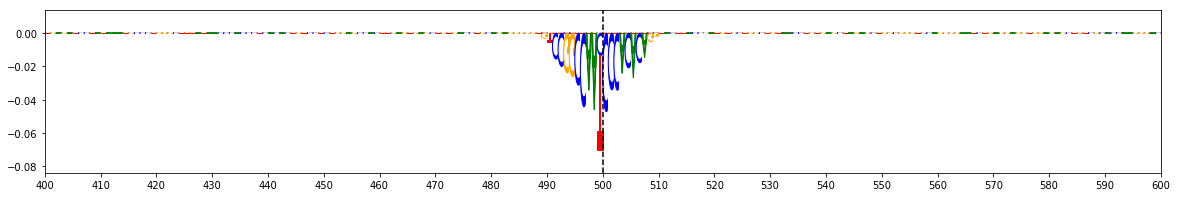


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 253   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4929   ||  Center / 200bp: 0.6174
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


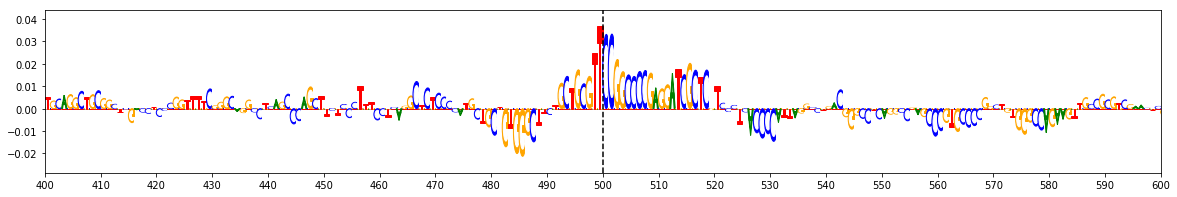

Noneffect Allele: C   ||  Explain Score: 0.2578   ||  Center / 200bp: 0.4581
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


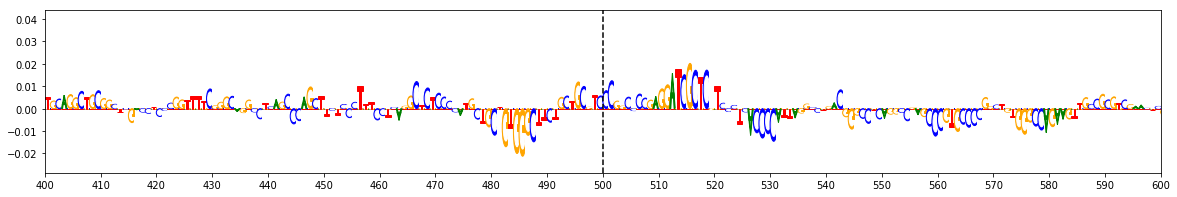

Allele Ratio : 1.9116   ||   Allele Difference : 0.2468  ||  ISM Score : 0.3905  ||  deltaSVM Score : 2.271


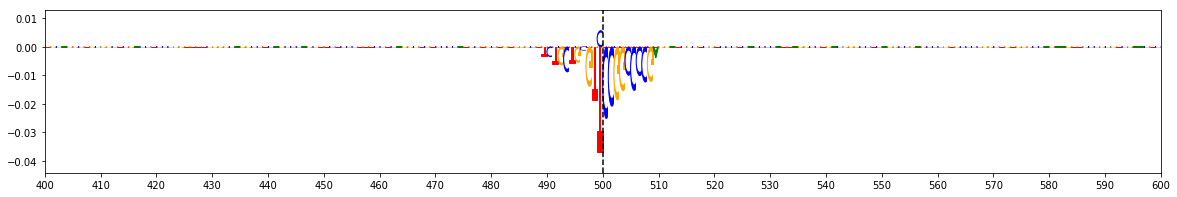


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 305   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.73E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.3175   ||  Center / 200bp: 0.2466
Effect Sequence: CCATGGGGCGGAGGCAGGGC


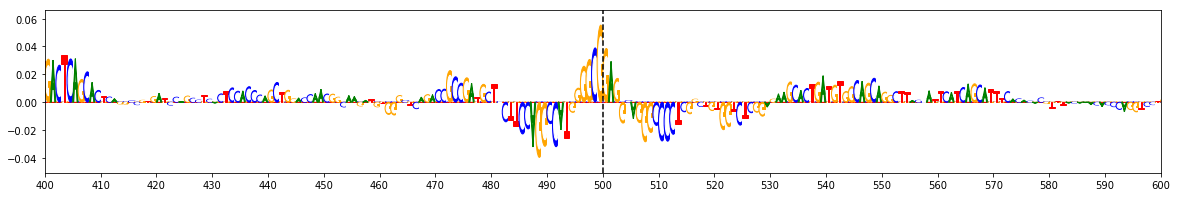

Noneffect Allele: A   ||  Explain Score: 0.0706   ||  Center / 200bp: 0.0678
Noneffect Sequence: CCATGGGGCAGAGGCAGGGC


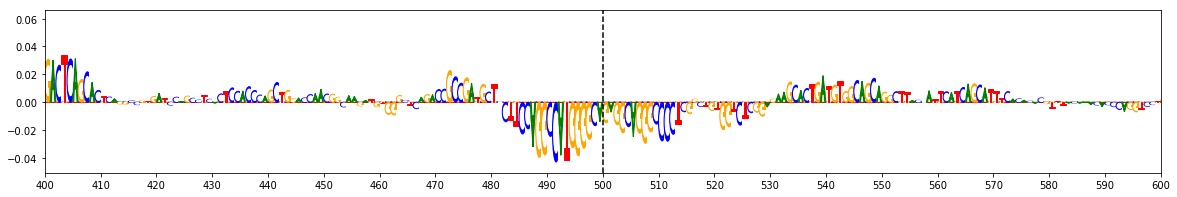

Allele Ratio : 4.4982   ||   Allele Difference : 0.5447  ||  ISM Score : 0.8518  ||  deltaSVM Score : 4.8999


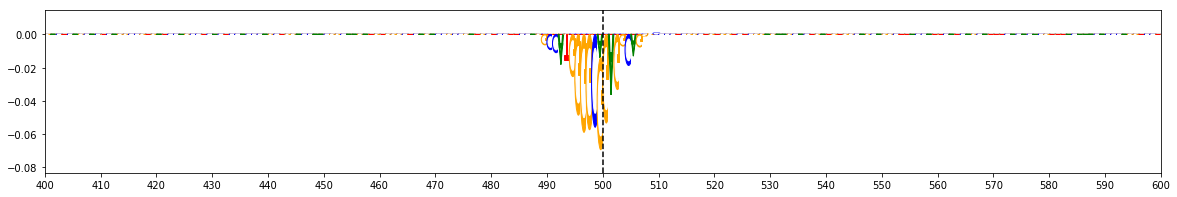


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7900536   ||    chr10 : 80493944 - 80493945   ||    Locus: 13   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  2.91E-05

Coloc:  True

Effect Allele: A   ||  Explain Score: 1.5822   ||  Center / 200bp: 0.6925
Effect Sequence: GGATGATTCAGATAATGTCT


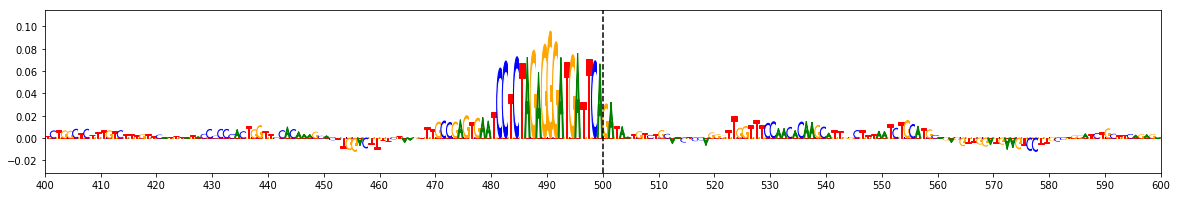

Noneffect Allele: C   ||  Explain Score: 1.0642   ||  Center / 200bp: 0.6021
Noneffect Sequence: GGATGATTCCGATAATGTCT


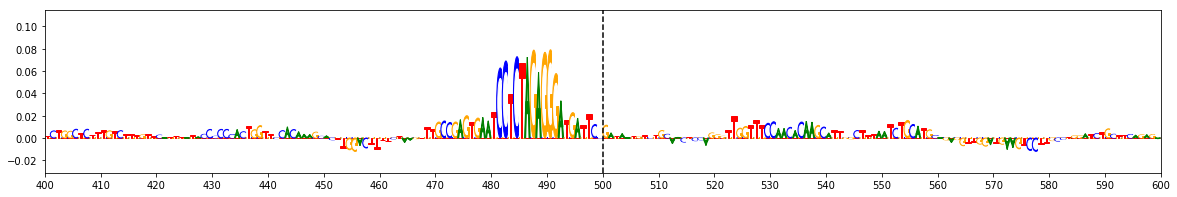

Allele Ratio : 1.4867   ||   Allele Difference : 0.518  ||  ISM Score : 0.806  ||  deltaSVM Score : 4.7867


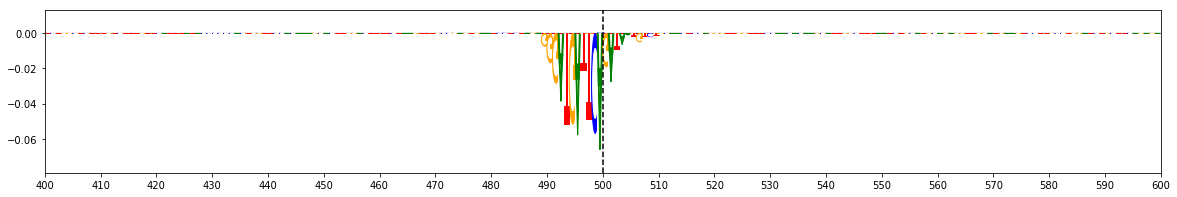


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6500328   ||    chr16 : 50702744 - 50702745   ||    Locus: 79   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  8.97E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.8675   ||  Center / 200bp: 0.6805
Effect Sequence: CACAAGGGTGTAGTGTGACT


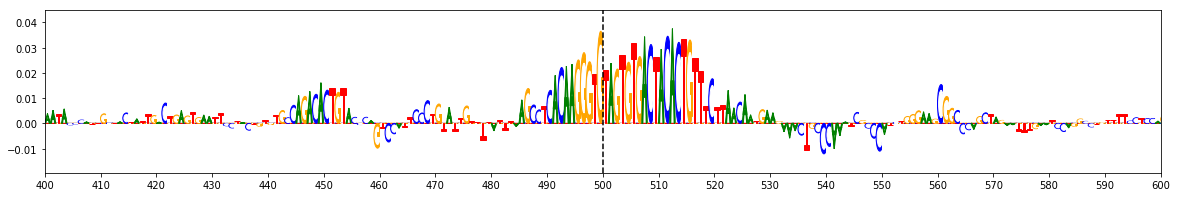

Noneffect Allele: A   ||  Explain Score: 0.586   ||  Center / 200bp: 0.5903
Noneffect Sequence: CACAAGGGTATAGTGTGACT


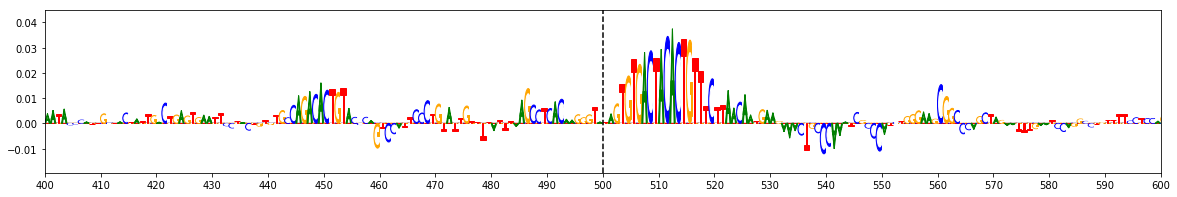

Allele Ratio : 1.4804   ||   Allele Difference : 0.2815  ||  ISM Score : 0.435  ||  deltaSVM Score : 2.5507


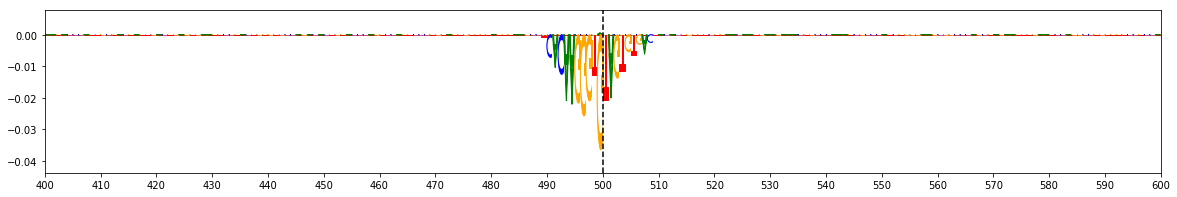


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11691237   ||    chr2 : 127084806 - 127084807   ||    Locus: 270   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  5.22E-08

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.8743   ||  Center / 200bp: 0.6559
Effect Sequence: CTCTGAGCCTATTGCAGTGT


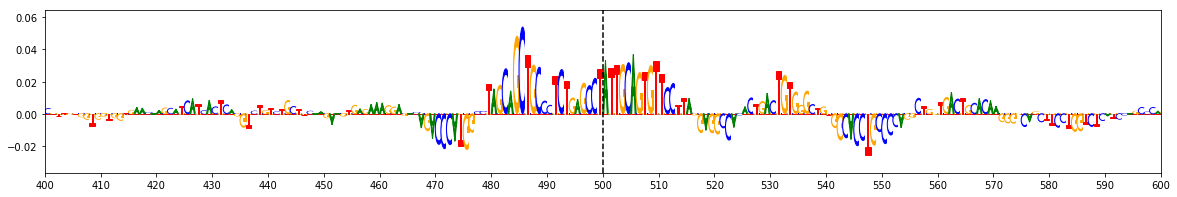

Noneffect Allele: C   ||  Explain Score: 0.608   ||  Center / 200bp: 0.5701
Noneffect Sequence: CTCTGAGCCCATTGCAGTGT


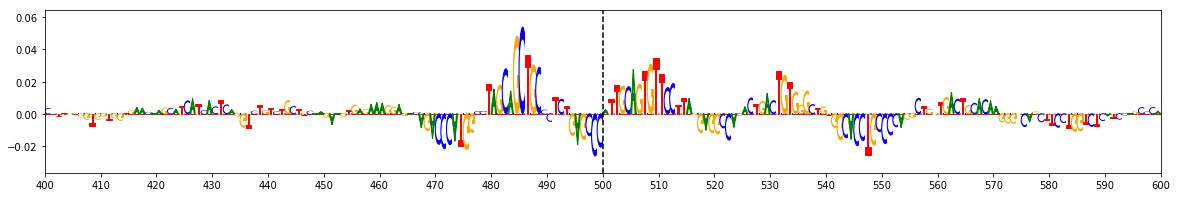

Allele Ratio : 1.4379   ||   Allele Difference : 0.3805  ||  ISM Score : 0.5974  ||  deltaSVM Score : 3.4485


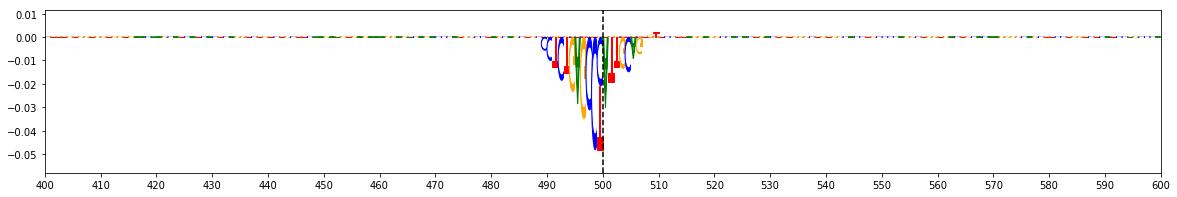


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 153   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.163   ||  Center / 200bp: 0.5766
Effect Sequence: GCCCGCCGCTAGGGGTTGCA


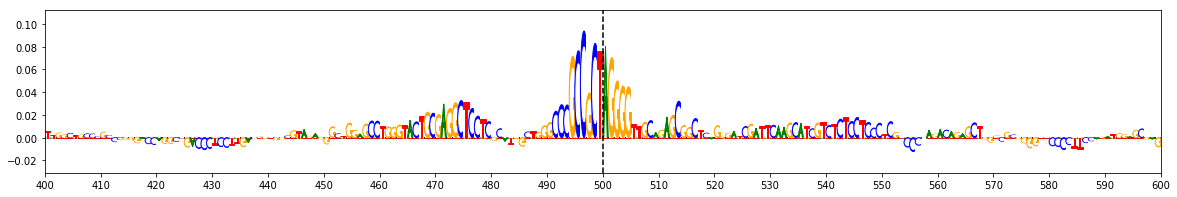

Noneffect Allele: G   ||  Explain Score: 0.7859   ||  Center / 200bp: 0.4794
Noneffect Sequence: GCCCGCCGCGAGGGGTTGCA


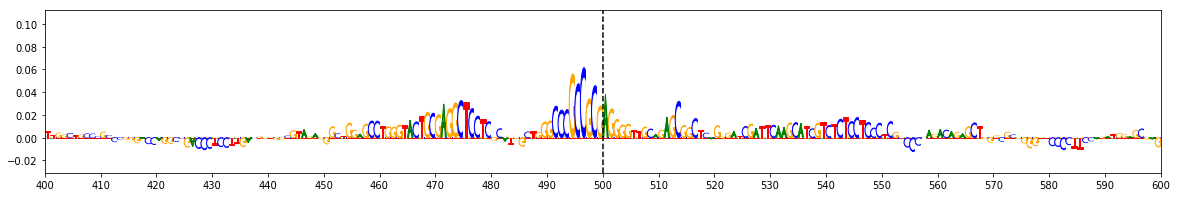

Allele Ratio : 1.4799   ||   Allele Difference : 0.3772  ||  ISM Score : 0.5887  ||  deltaSVM Score : 3.339


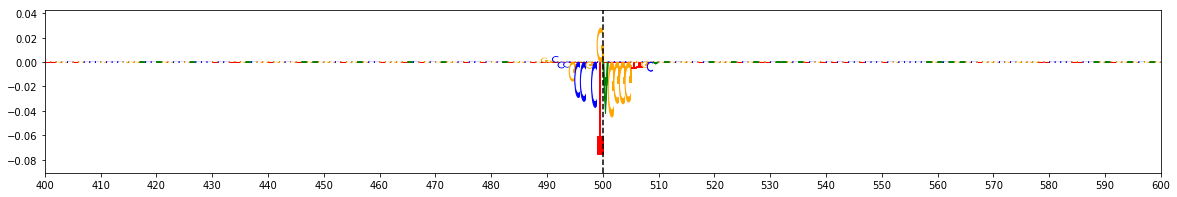


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3776870   ||    chr5 : 102959365 - 102959366   ||    Locus: 346   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.39E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.3586   ||  Center / 200bp: 0.5231
Effect Sequence: AAGGAGGCAGTTAACCAAAA


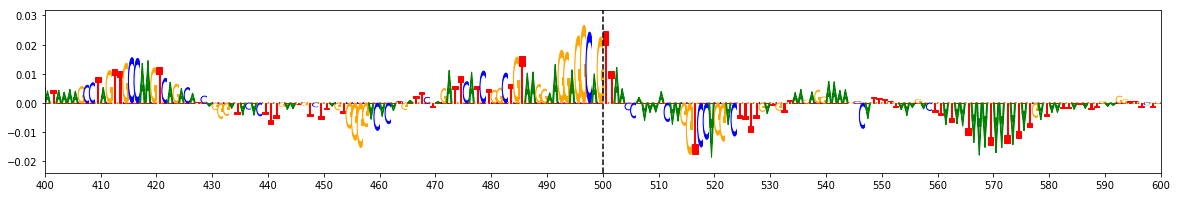

Noneffect Allele: A   ||  Explain Score: 0.2237   ||  Center / 200bp: 0.4062
Noneffect Sequence: AAGGAGGCAATTAACCAAAA


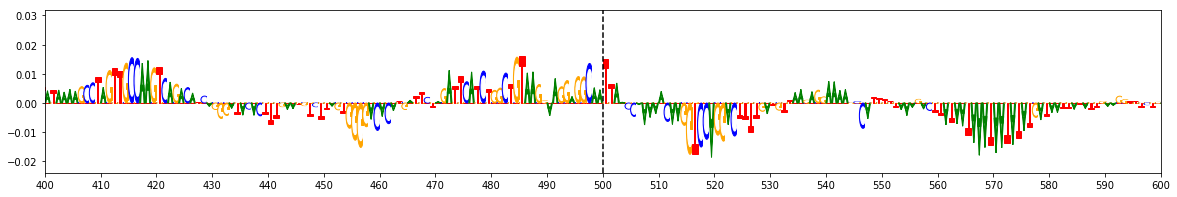

Allele Ratio : 1.6034   ||   Allele Difference : 0.1428  ||  ISM Score : 0.224  ||  deltaSVM Score : 1.3205


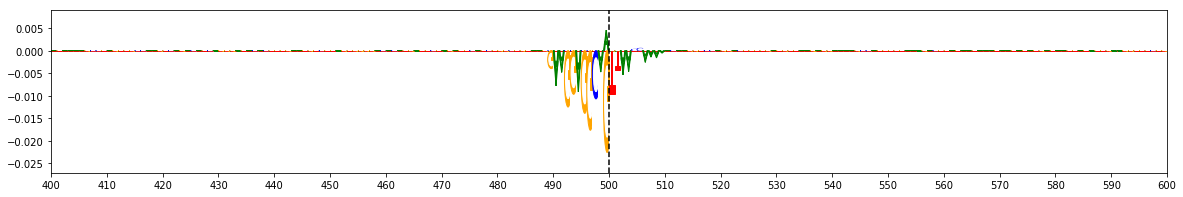


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12073680   ||    chr1 : 232508907 - 232508908   ||    Locus: 8   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.90E-03
Nalls_23andMe 		  3.90E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.1448   ||  Center / 200bp: 0.3737
Effect Sequence: CTGGCCAACGCGGCGAAACC


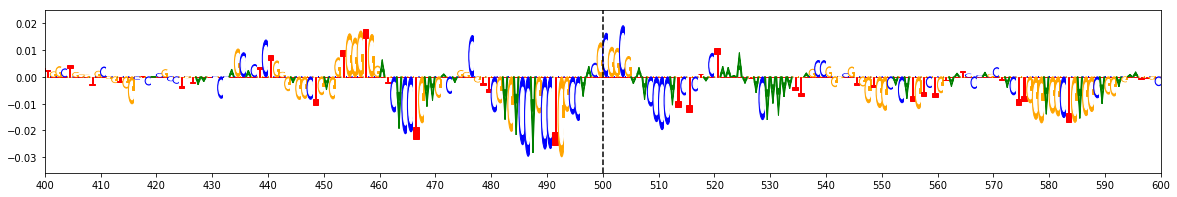

Noneffect Allele: A   ||  Explain Score: 0.0645   ||  Center / 200bp: 0.2103
Noneffect Sequence: CTGGCCAACACGGCGAAACC


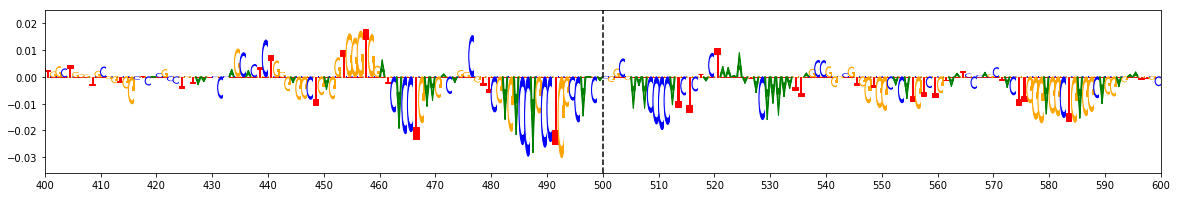

Allele Ratio : 2.2438   ||   Allele Difference : 0.1106  ||  ISM Score : 0.1766  ||  deltaSVM Score : 1.0014


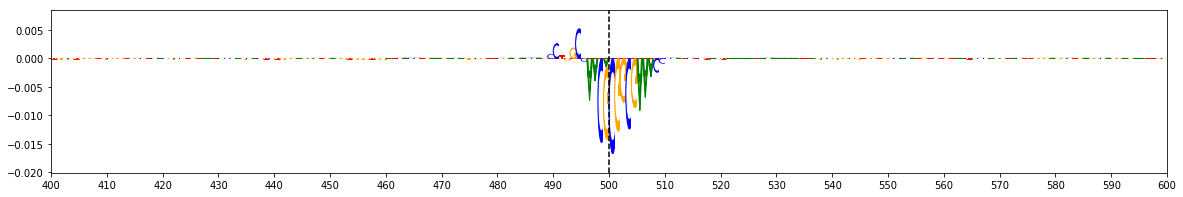


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62057150   ||    chr17 : 45826181 - 45826182   ||    Locus: 135   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.33E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6187   ||  Center / 200bp: 0.6542
Effect Sequence: CGTGGCCATTGGTCGGGGTG


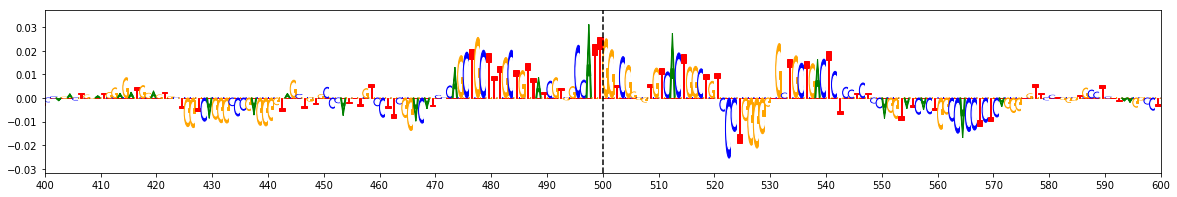

Noneffect Allele: C   ||  Explain Score: 0.4912   ||  Center / 200bp: 0.5999
Noneffect Sequence: CGTGGCCATCGGTCGGGGTG


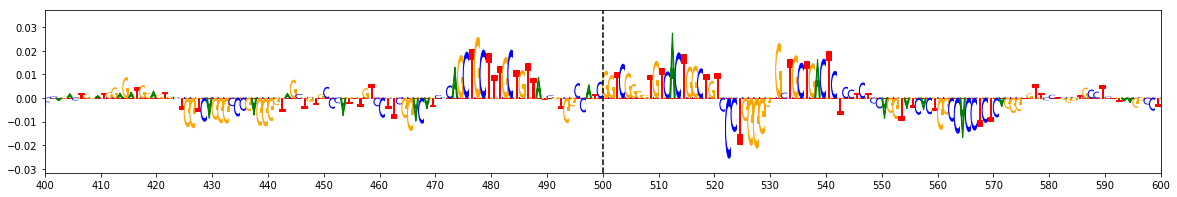

Allele Ratio : 1.2596   ||   Allele Difference : 0.1496  ||  ISM Score : 0.2384  ||  deltaSVM Score : 1.3782


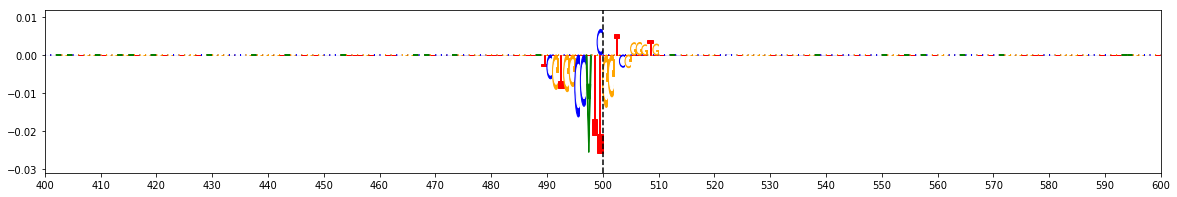


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs754366   ||    chr19 : 45130427 - 45130428   ||    Locus: 257   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.90E-37
Alzheimers_Kunkle_2019 		  6.95E-24
Alzheimers_Lambert_2013 	  9.04E-21

Coloc:  True

Effect Allele: A   ||  Explain Score: 0.9795   ||  Center / 200bp: 0.6251
Effect Sequence: TCCCCTCCCAGTGTGCTTTG


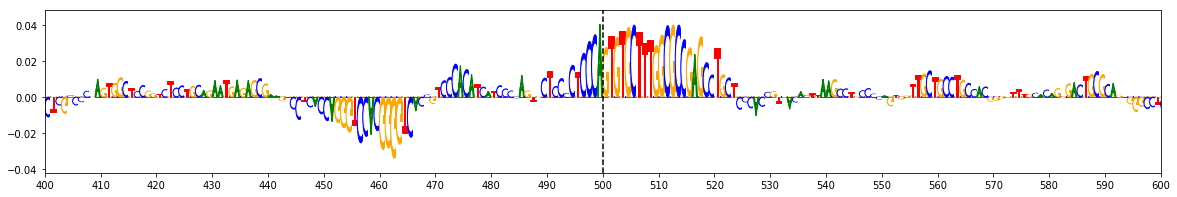

Noneffect Allele: G   ||  Explain Score: 0.7505   ||  Center / 200bp: 0.5606
Noneffect Sequence: TCCCCTCCCGGTGTGCTTTG


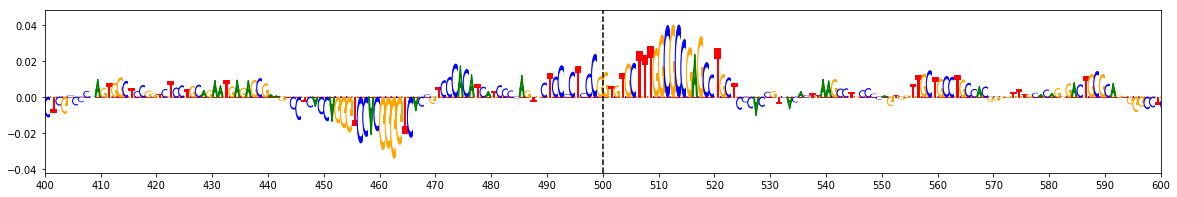

Allele Ratio : 1.3051   ||   Allele Difference : 0.229  ||  ISM Score : 0.3611  ||  deltaSVM Score : 2.0511


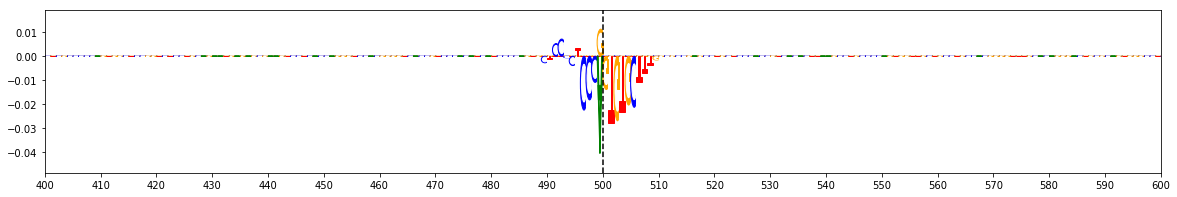


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 187   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.9421   ||  Center / 200bp: 0.4442
Effect Sequence: GCCCTCCTGCGCCACCTACA


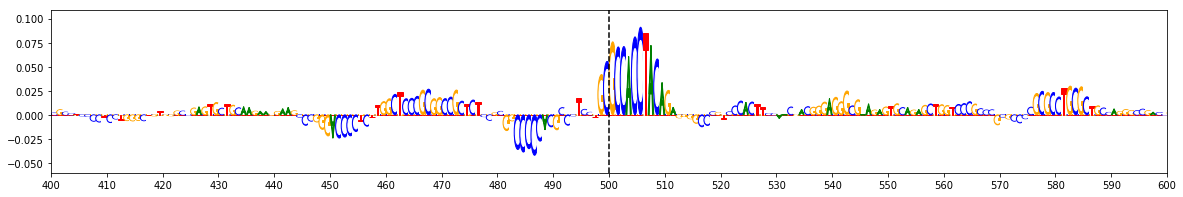

Noneffect Allele: A   ||  Explain Score: 0.522   ||  Center / 200bp: 0.3065
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


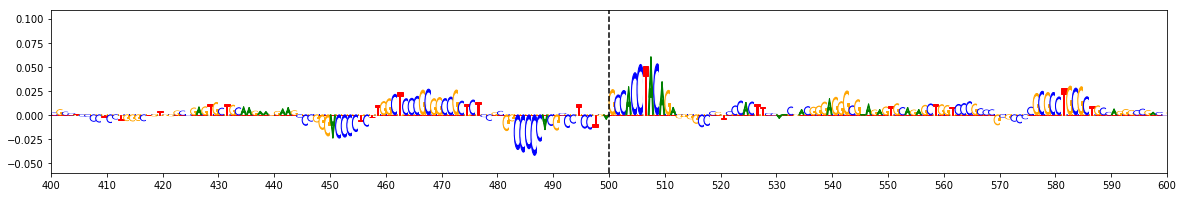

Allele Ratio : 1.8048   ||   Allele Difference : 0.4733  ||  ISM Score : 0.7516  ||  deltaSVM Score : 4.309


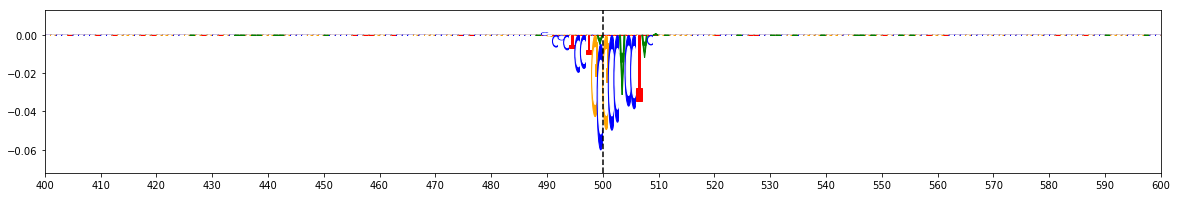


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62056906   ||    chr17 : 45705341 - 45705342   ||    Locus: 113   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.10E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6501   ||  Center / 200bp: 0.609
Effect Sequence: CACTCTTGCTTCCAGTCCCA


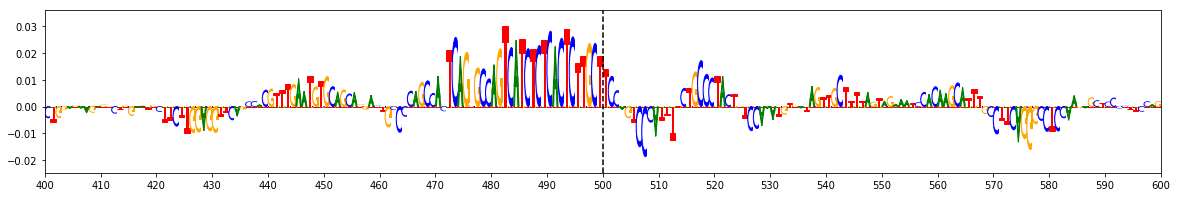

Noneffect Allele: C   ||  Explain Score: 0.5078   ||  Center / 200bp: 0.5486
Noneffect Sequence: CACTCTTGCCTCCAGTCCCA


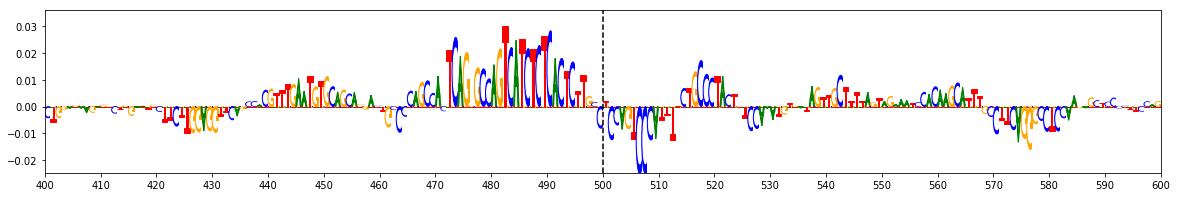

Allele Ratio : 1.2803   ||   Allele Difference : 0.2116  ||  ISM Score : 0.3317  ||  deltaSVM Score : 1.9201


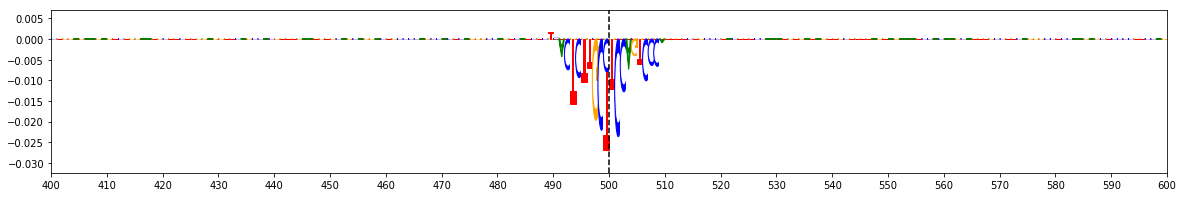


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62063271   ||    chr17 : 45958680 - 45958681   ||    Locus: 169   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.78E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.4189   ||  Center / 200bp: 0.5101
Effect Sequence: GATCACACCGCTGCACTCCA


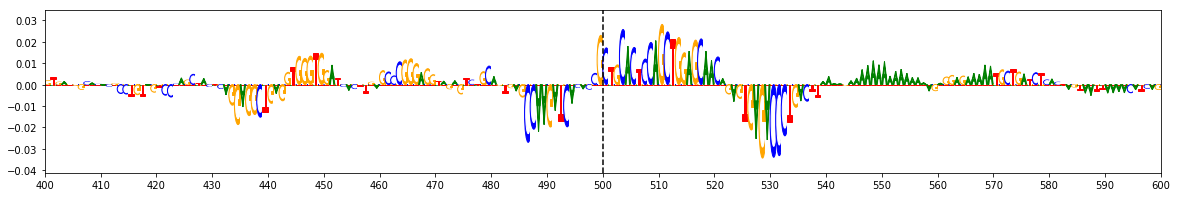

Noneffect Allele: A   ||  Explain Score: 0.2863   ||  Center / 200bp: 0.4159
Noneffect Sequence: GATCACACCACTGCACTCCA


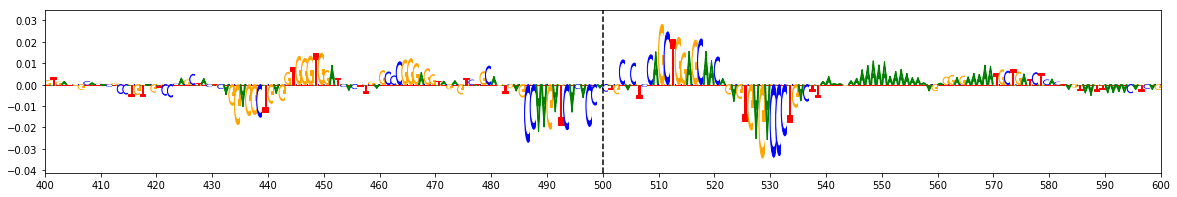

Allele Ratio : 1.463   ||   Allele Difference : 0.195  ||  ISM Score : 0.323  ||  deltaSVM Score : 1.9205


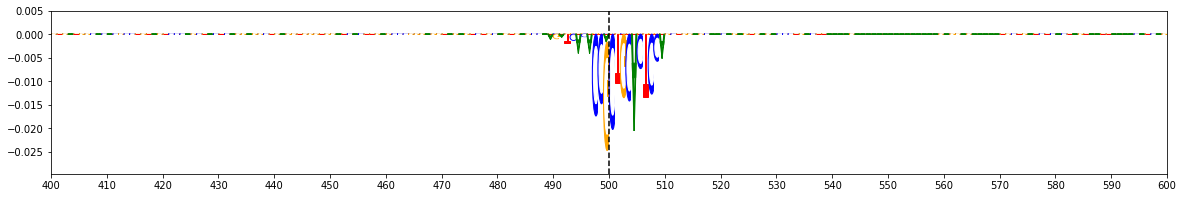


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147889095   ||    chr1 : 226737182 - 226737183   ||    Locus: 7   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.77E-05
Nalls_23andMe 		  1.77E-05

Coloc:  False

Effect Allele: I   ||  Explain Score: 0.7441   ||  Center / 200bp: 0.6061
Effect Sequence: ACTGCCGCTGCCACTGCCGC


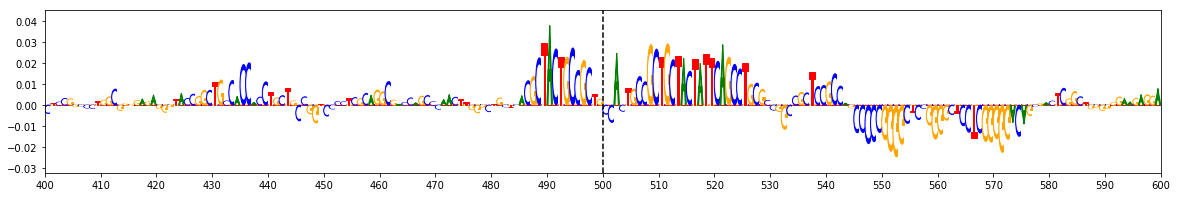

Noneffect Allele: D   ||  Explain Score: 0.6069   ||  Center / 200bp: 0.5123
Noneffect Sequence: ACTGCCGCTGCTGCCGCTGC


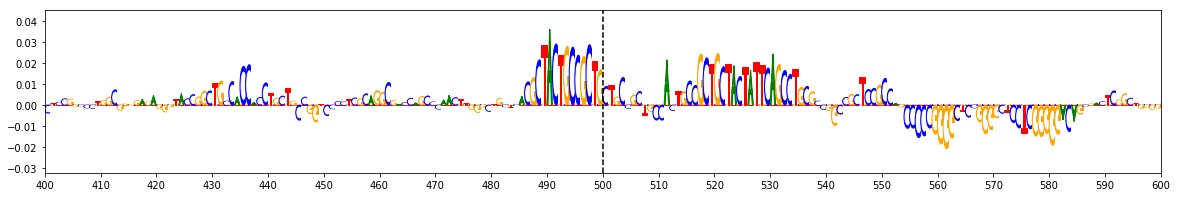

Allele Ratio : 1.226   ||   Allele Difference : 0.1472  ||  ISM Score : 0.1701  ||  deltaSVM Score : 0.8063


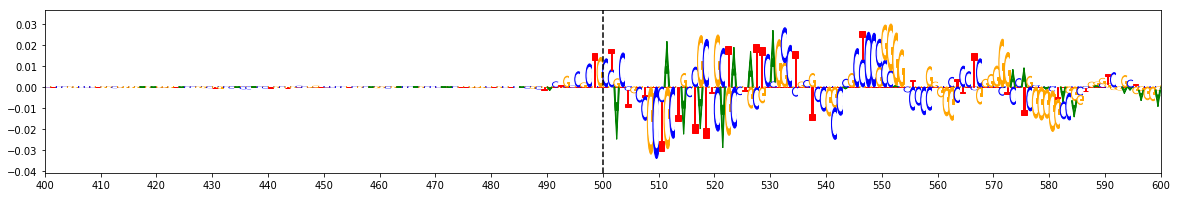


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 34   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.0545   ||  Center / 200bp: 0.5036
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


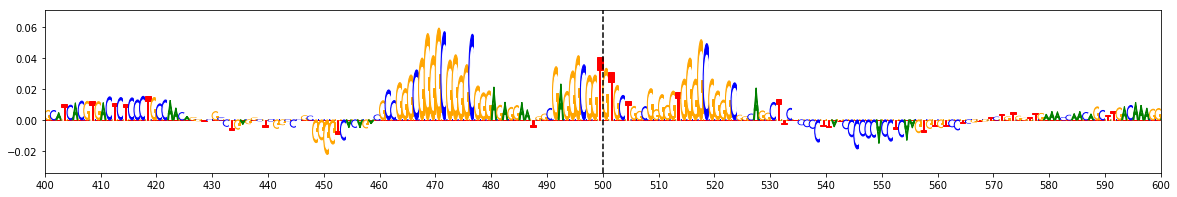

Noneffect Allele: C   ||  Explain Score: 0.7169   ||  Center / 200bp: 0.4085
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


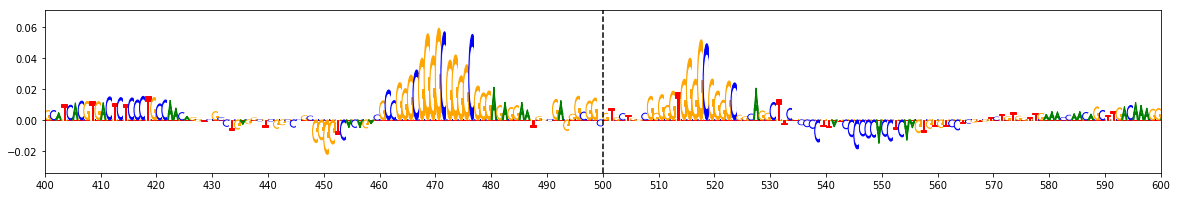

Allele Ratio : 1.471   ||   Allele Difference : 0.3494  ||  ISM Score : 0.5819  ||  deltaSVM Score : 3.4361


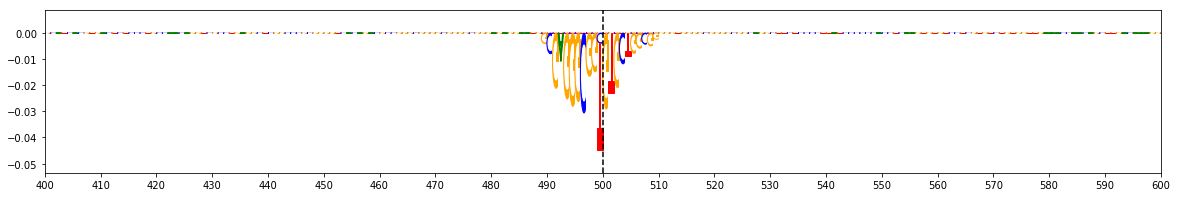


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62057109   ||    chr17 : 45819270 - 45819271   ||    Locus: 129   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  1.42E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.9375   ||  Center / 200bp: 0.6059
Effect Sequence: TGTAGGAGCTGCTATTCAGA


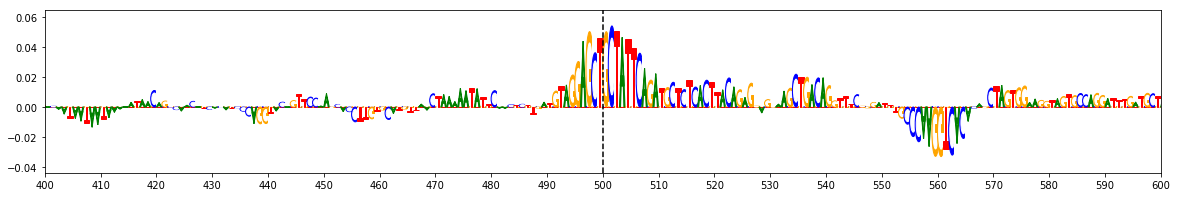

Noneffect Allele: C   ||  Explain Score: 0.781   ||  Center / 200bp: 0.5613
Noneffect Sequence: TGTAGGAGCCGCTATTCAGA


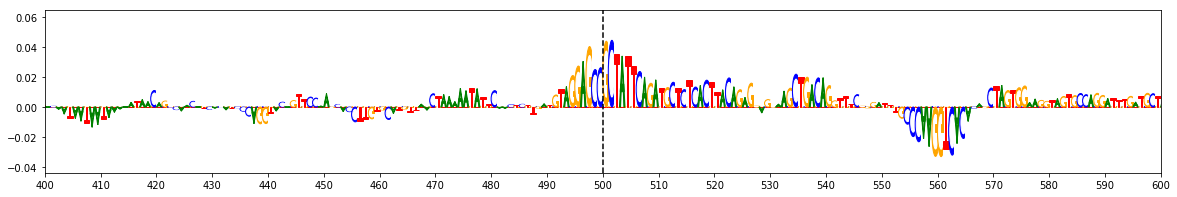

Allele Ratio : 1.2004   ||   Allele Difference : 0.1565  ||  ISM Score : 0.243  ||  deltaSVM Score : 1.4088


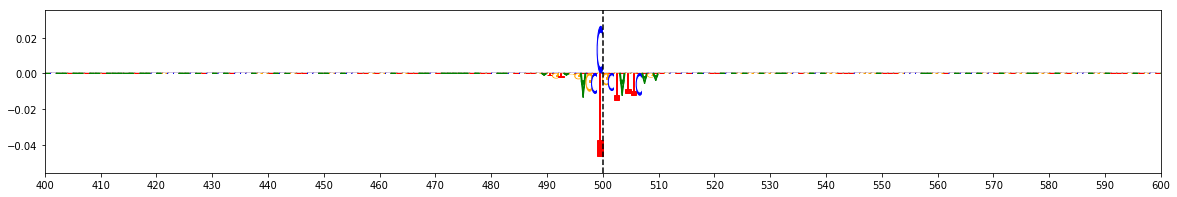


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs142524806   ||    chr17 : 46130533 - 46130534   ||    Locus: 182   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.72E-22

Coloc:  True

Effect Allele: I   ||  Explain Score: 0.6292   ||  Center / 200bp: 0.649
Effect Sequence: TTCATACATACTCAAACAGT


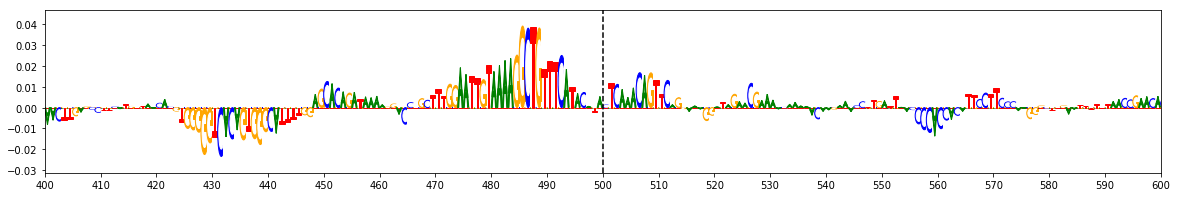

Noneffect Allele: D   ||  Explain Score: 0.5618   ||  Center / 200bp: 0.6231
Noneffect Sequence: TTCATACATACAAACAGTTC


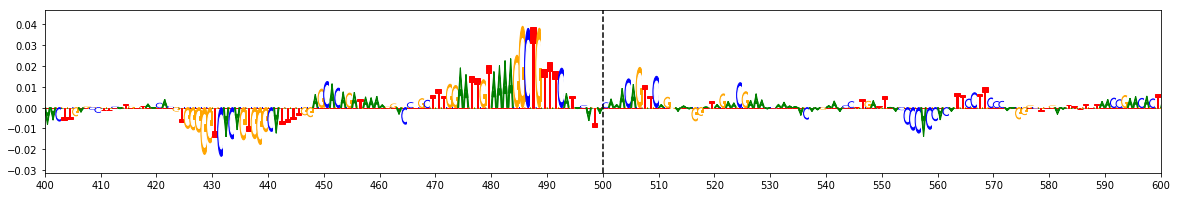

Allele Ratio : 1.1199   ||   Allele Difference : 0.0843  ||  ISM Score : 0.1701  ||  deltaSVM Score : 1.0238


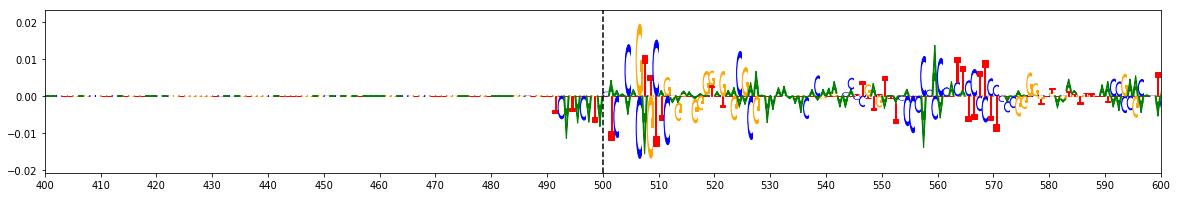


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()